### MACHINE LEARNING MODELS FOR THE BANK MARKETING DATASET (RAW)

First of all, we will perform data curation and preparation. Next, we will apply the following Machine Learning models:

- Linear Regression
- k-Nearest Neighbors(k-NN)
- Support Vector Machines (SVM)
- Classification Trees
- Random Forest
- Ada Boosting
- Gradient Boosting
- Neural Networks(NN)

**Import the necessary libraries:**

We try to eliminate the warnings that come up when some cells are executed:

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn("ignore")
warnings.simplefilter('ignore')

Now we import the libraries needed for executing the models and visualize the plots:

In [2]:
from imblearn.over_sampling import SMOTE

In [3]:
%matplotlib inline
import pandas as pd
import pandas_profiling as pp
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, make_scorer, roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import shap
import matplotlib.pyplot as plt
import seaborn as sns

**Load the dataset**

In [4]:
df = pd.read_csv("bank-additional-full_raw.csv", sep=";")

**We check that we have loaded the dataset correctly by showing the first 5 rows of the dataset**

In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


**We explore the original dataset**

In [6]:
print(df.head())
print(df.info())
print(df.describe())
print(df.shape)

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

**We check if there is any null value to remove it if exists:**

In [7]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

**We remove columns that are not relevant to our analysis:**
http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Duration is dropped as the attribute highly affects the outcome of the predictions. This happens beacuse if the duration is cero or any other low value, it means that the call has been really short and no customers subscribed to the banking product. On the other hand, if the call was long enough, it usually means that the client did subscribe to the proposed product. Therefore, this attribute is dropped from the dataset for the analysis.

In [8]:
df = df.drop(["duration", "campaign", "pdays", "previous", "poutcome", "nr.employed"], axis=1)

**First data exploration for understanding the data we have in the dataset:**

We make use of Pandas profiling to generate a complete report that will be relevant for future analysis in working memory:

In [9]:
# forming ProfileReport and save as output.html file
profile = pp.ProfileReport(df)
profile.to_file("dataset_bank_no_anonym_initial_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 215.57it/s]


We proceed to create more complex graphs that give us more information from the original dataset before we begin to transform the dataset and anonymise it for future analysis.

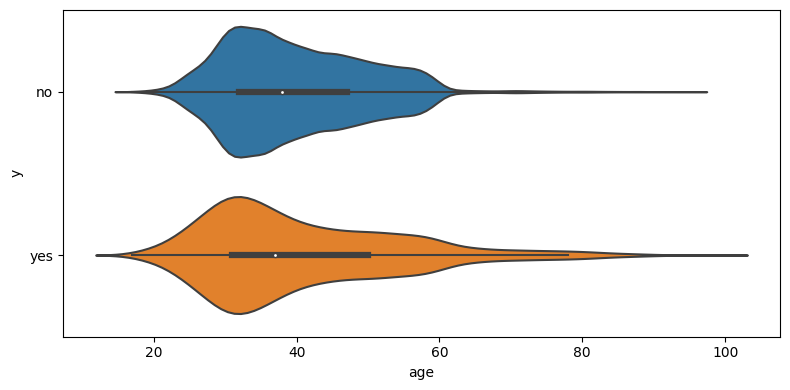

In [10]:
# Selecting all columns except the target ('y')
features_to_plot = ['age']

# Calculate the appropriate figure size based on the number of features
fig_height = len(features_to_plot) * 4
fig, axes = plt.subplots(nrows=len(features_to_plot), figsize=(8, fig_height))

# Iterate over each feature and generate the violinplot
for i, feature in enumerate(features_to_plot):
    ax = axes[i] if len(features_to_plot) > 1 else axes
    sns.violinplot(data=df, x=feature, y='y', ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('y')

# Adjust the spacing between subplots and show the figure
plt.tight_layout()
plt.show()

**Convert categorical to factors and store in a dictionary all the mapping:**

We discretise the variables in order to better manage the data in the dataset.

In [11]:
df["job"] = df["job"].astype("category").cat.codes
df["marital"] = df["marital"].astype("category").cat.codes
df["education"] = df["education"].astype("category").cat.codes
df["default"] = df["default"].astype("category").cat.codes
df["housing"] = df["housing"].astype("category").cat.codes
df["loan"] = df["loan"].astype("category").cat.codes
df["contact"] = df["contact"].astype("category").cat.codes
df["month"] = df["month"].astype("category").cat.codes
df["day_of_week"] = df["day_of_week"].astype("category").cat.codes
df["y"] = df["y"].astype("category").cat.codes


We inspect the dataset to make sure everything has work properly:

In [12]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,y
0,56,3,1,0,0,0,0,1,6,1,1.1,93.994,-36.4,4.857,0
1,57,7,1,3,1,0,0,1,6,1,1.1,93.994,-36.4,4.857,0
2,37,7,1,3,0,2,0,1,6,1,1.1,93.994,-36.4,4.857,0
3,40,0,1,1,0,0,0,1,6,1,1.1,93.994,-36.4,4.857,0
4,56,7,1,3,0,0,2,1,6,1,1.1,93.994,-36.4,4.857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5,1,5,0,2,0,0,7,0,-1.1,94.767,-50.8,1.028,1
41184,46,1,1,5,0,0,0,0,7,0,-1.1,94.767,-50.8,1.028,0
41185,56,5,1,6,0,2,0,0,7,0,-1.1,94.767,-50.8,1.028,0
41186,44,9,1,5,0,0,0,0,7,0,-1.1,94.767,-50.8,1.028,1


Before starting we have to define a random state value in order to achieve reproducibility of the models:

In [13]:
random_seed = 14

**We divide the dataset in train and test**

In [14]:
X = df.drop(["y"], axis=1)
y = df["y"]

# We add stratify for making sure that the random split has 25% of 0's and 75% of 1's.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed, stratify=y)

**We check that the shapes of the splitted sets are correct as expected**

In [15]:
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train:",y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (30891, 14)
X_test shape: (10297, 14)
y_train: (30891,)
y_test shape: (10297,)


**Finally we do the scaling in train and test separately**

We scale variables separately in train and test because this way we avoid biases. In addition, we manage to maintain the relative scale, i.e., all characteristics have a similar scale.

In [16]:
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

We check the new scaled values in the respectivew partitions created:

In [17]:
X_train

array([[0.23076923, 0.        , 0.33333333, ..., 0.3893219 , 0.36820084,
        0.79029698],
       [0.29487179, 0.        , 0.33333333, ..., 0.3893219 , 0.36820084,
        0.80639311],
       [0.17948718, 0.09090909, 0.66666667, ..., 0.26968044, 0.19246862,
        0.15869417],
       ...,
       [0.20512821, 0.09090909, 0.33333333, ..., 0.69875292, 0.60251046,
        0.95783269],
       [0.30769231, 0.09090909, 0.33333333, ..., 0.66913484, 0.33891213,
        0.98072999],
       [0.33333333, 0.18181818, 0.33333333, ..., 0.69875292, 0.60251046,
        0.95737928]])

In [18]:
X_test

array([[0.1025641 , 0.        , 0.66666667, ..., 0.69875292, 0.60251046,
        0.9580594 ],
       [0.24358974, 0.        , 0.33333333, ..., 0.66913484, 0.33891213,
        0.9809567 ],
       [0.16666667, 0.        , 0.        , ..., 0.66913484, 0.33891213,
        0.9809567 ],
       ...,
       [0.16666667, 0.09090909, 0.33333333, ..., 0.66913484, 0.33891213,
        0.98141011],
       [0.34615385, 0.        , 0.33333333, ..., 0.93530787, 0.05439331,
        0.08297438],
       [0.33333333, 0.09090909, 0.33333333, ..., 0.69875292, 0.60251046,
        0.95737928]])

### VIOLINPLOTS:

Before we start analysing the performance of the models, let's do some more plotting. We will start by making some violinplots for each of the relevant variables. In this way we can observe the distribution of each of our variables, and confront them with the target variable:

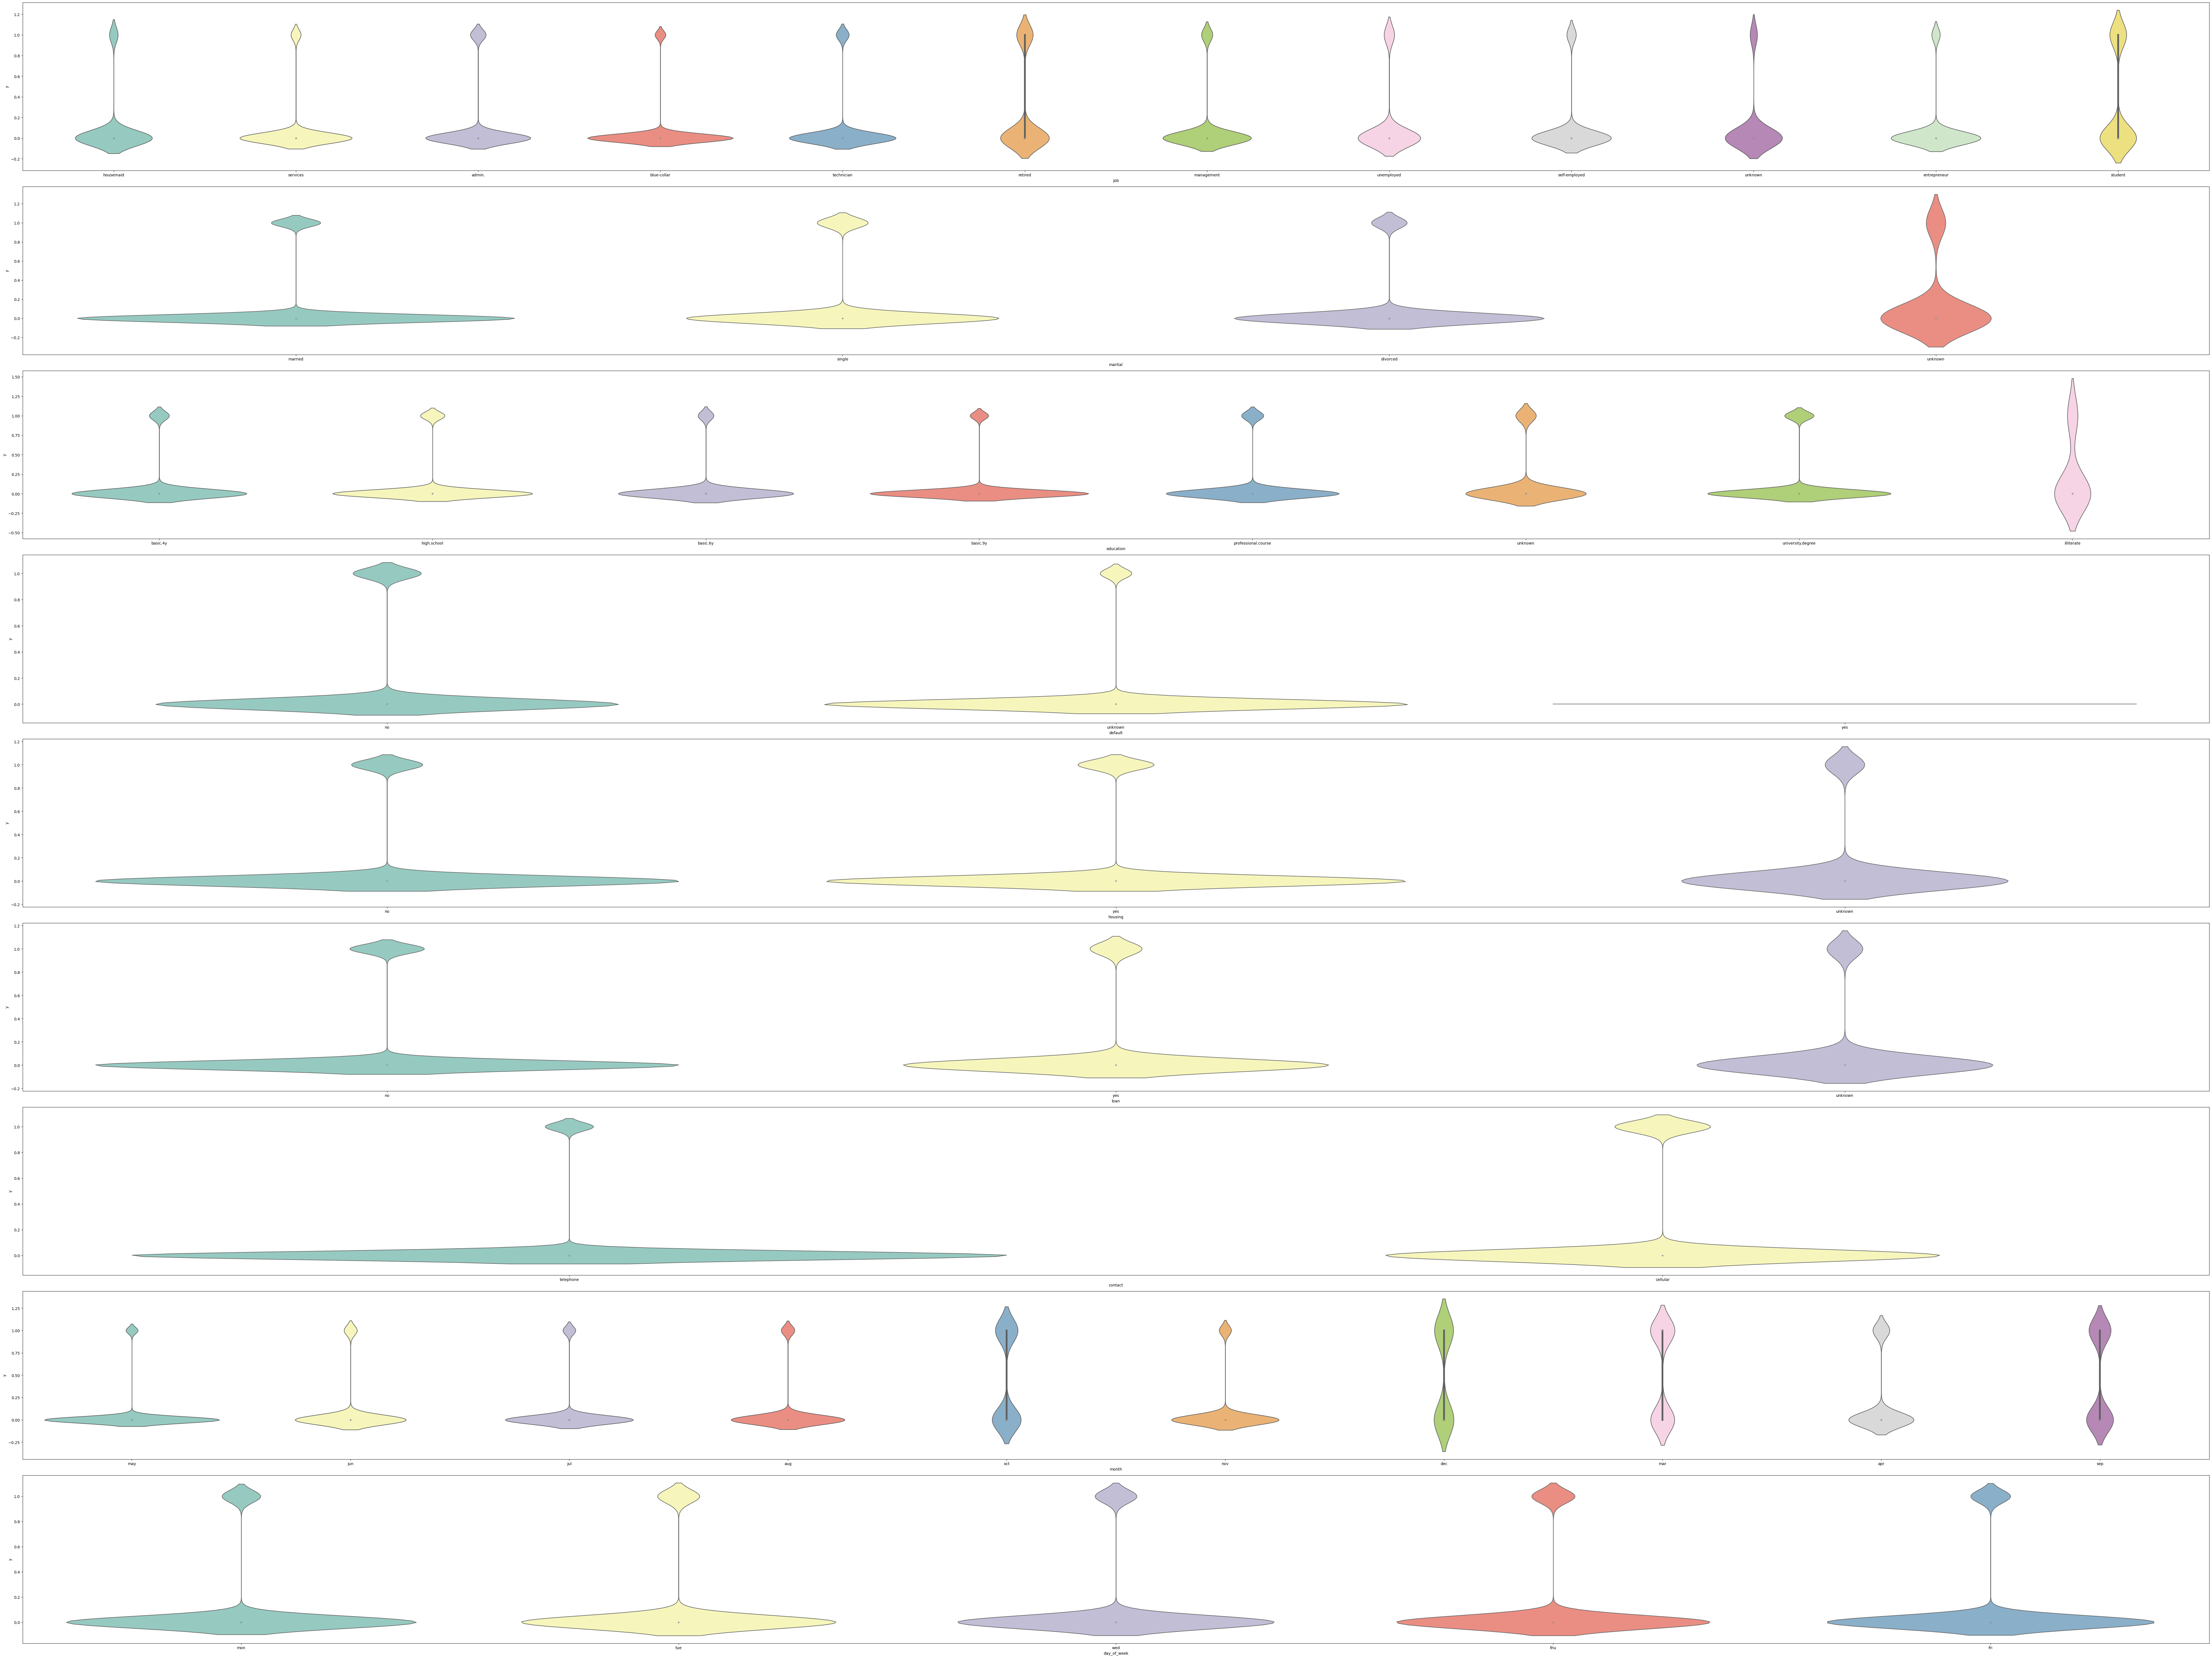

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dictionary to map the encoded values back to their original labels
job_mapping = {0: 'admin.', 1: 'blue-collar', 2: 'entrepreneur', 3: 'housemaid', 4: 'management', 5: 'retired',
               6: 'self-employed', 7: 'services', 8: 'student', 9: 'technician', 10: 'unemployed', 11: 'unknown'}
marital_mapping = {0: 'divorced', 1: 'married', 2: 'single', 3: 'unknown'}
education_mapping = {0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate',
                     5: 'professional.course', 6: 'university.degree', 7: 'unknown'}
default_mapping = {0: 'no', 1: 'unknown', 2: 'yes'}
housing_mapping = {0: 'no', 1: 'unknown', 2: 'yes'}
loan_mapping = {0: 'no', 1: 'unknown', 2: 'yes'}
contact_mapping = {0: 'cellular', 1: 'telephone'}
month_mapping = {0: 'apr', 1: 'aug', 2: 'dec', 3: 'jul', 4: 'jun', 5: 'mar', 6: 'may', 7: 'nov', 8: 'oct', 9: 'sep'}
day_of_week_mapping = {0: 'fri', 1: 'mon', 2: 'thu', 3: 'tue', 4: 'wed'}
y_mapping = {0: 'no', 1: 'yes'}

# Apply the mapping to the DataFrame
df["job"] = df["job"].map(job_mapping)
df["marital"] = df["marital"].map(marital_mapping)
df["education"] = df["education"].map(education_mapping)
df["default"] = df["default"].map(default_mapping)
df["housing"] = df["housing"].map(housing_mapping)
df["loan"] = df["loan"].map(loan_mapping)
df["contact"] = df["contact"].map(contact_mapping)
df["month"] = df["month"].map(month_mapping)
df["day_of_week"] = df["day_of_week"].map(day_of_week_mapping)

# Set the features to plot
features_to_plot = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week']

# Create a figure with subplots for each feature
fig, axes = plt.subplots(nrows=len(features_to_plot), figsize=(80, 60))

# Iterate over each feature and generate the violin plot
for i, feature in enumerate(features_to_plot):
    ax = axes[i] if len(features_to_plot) > 1 else axes
    sns.violinplot(data=df, x=feature, y='y', ax=ax, palette='Set3')
    ax.set_xlabel(feature)
    ax.set_ylabel('y')

# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

With the generated plots we can mainly see what the dispersion is. However, as most of the variables, except for age which was previously separated, only take a value of 0 or 1, we can represent it in a better way. For this purpose it is more appropriate to use bar plots:

### BAR PLOTS:

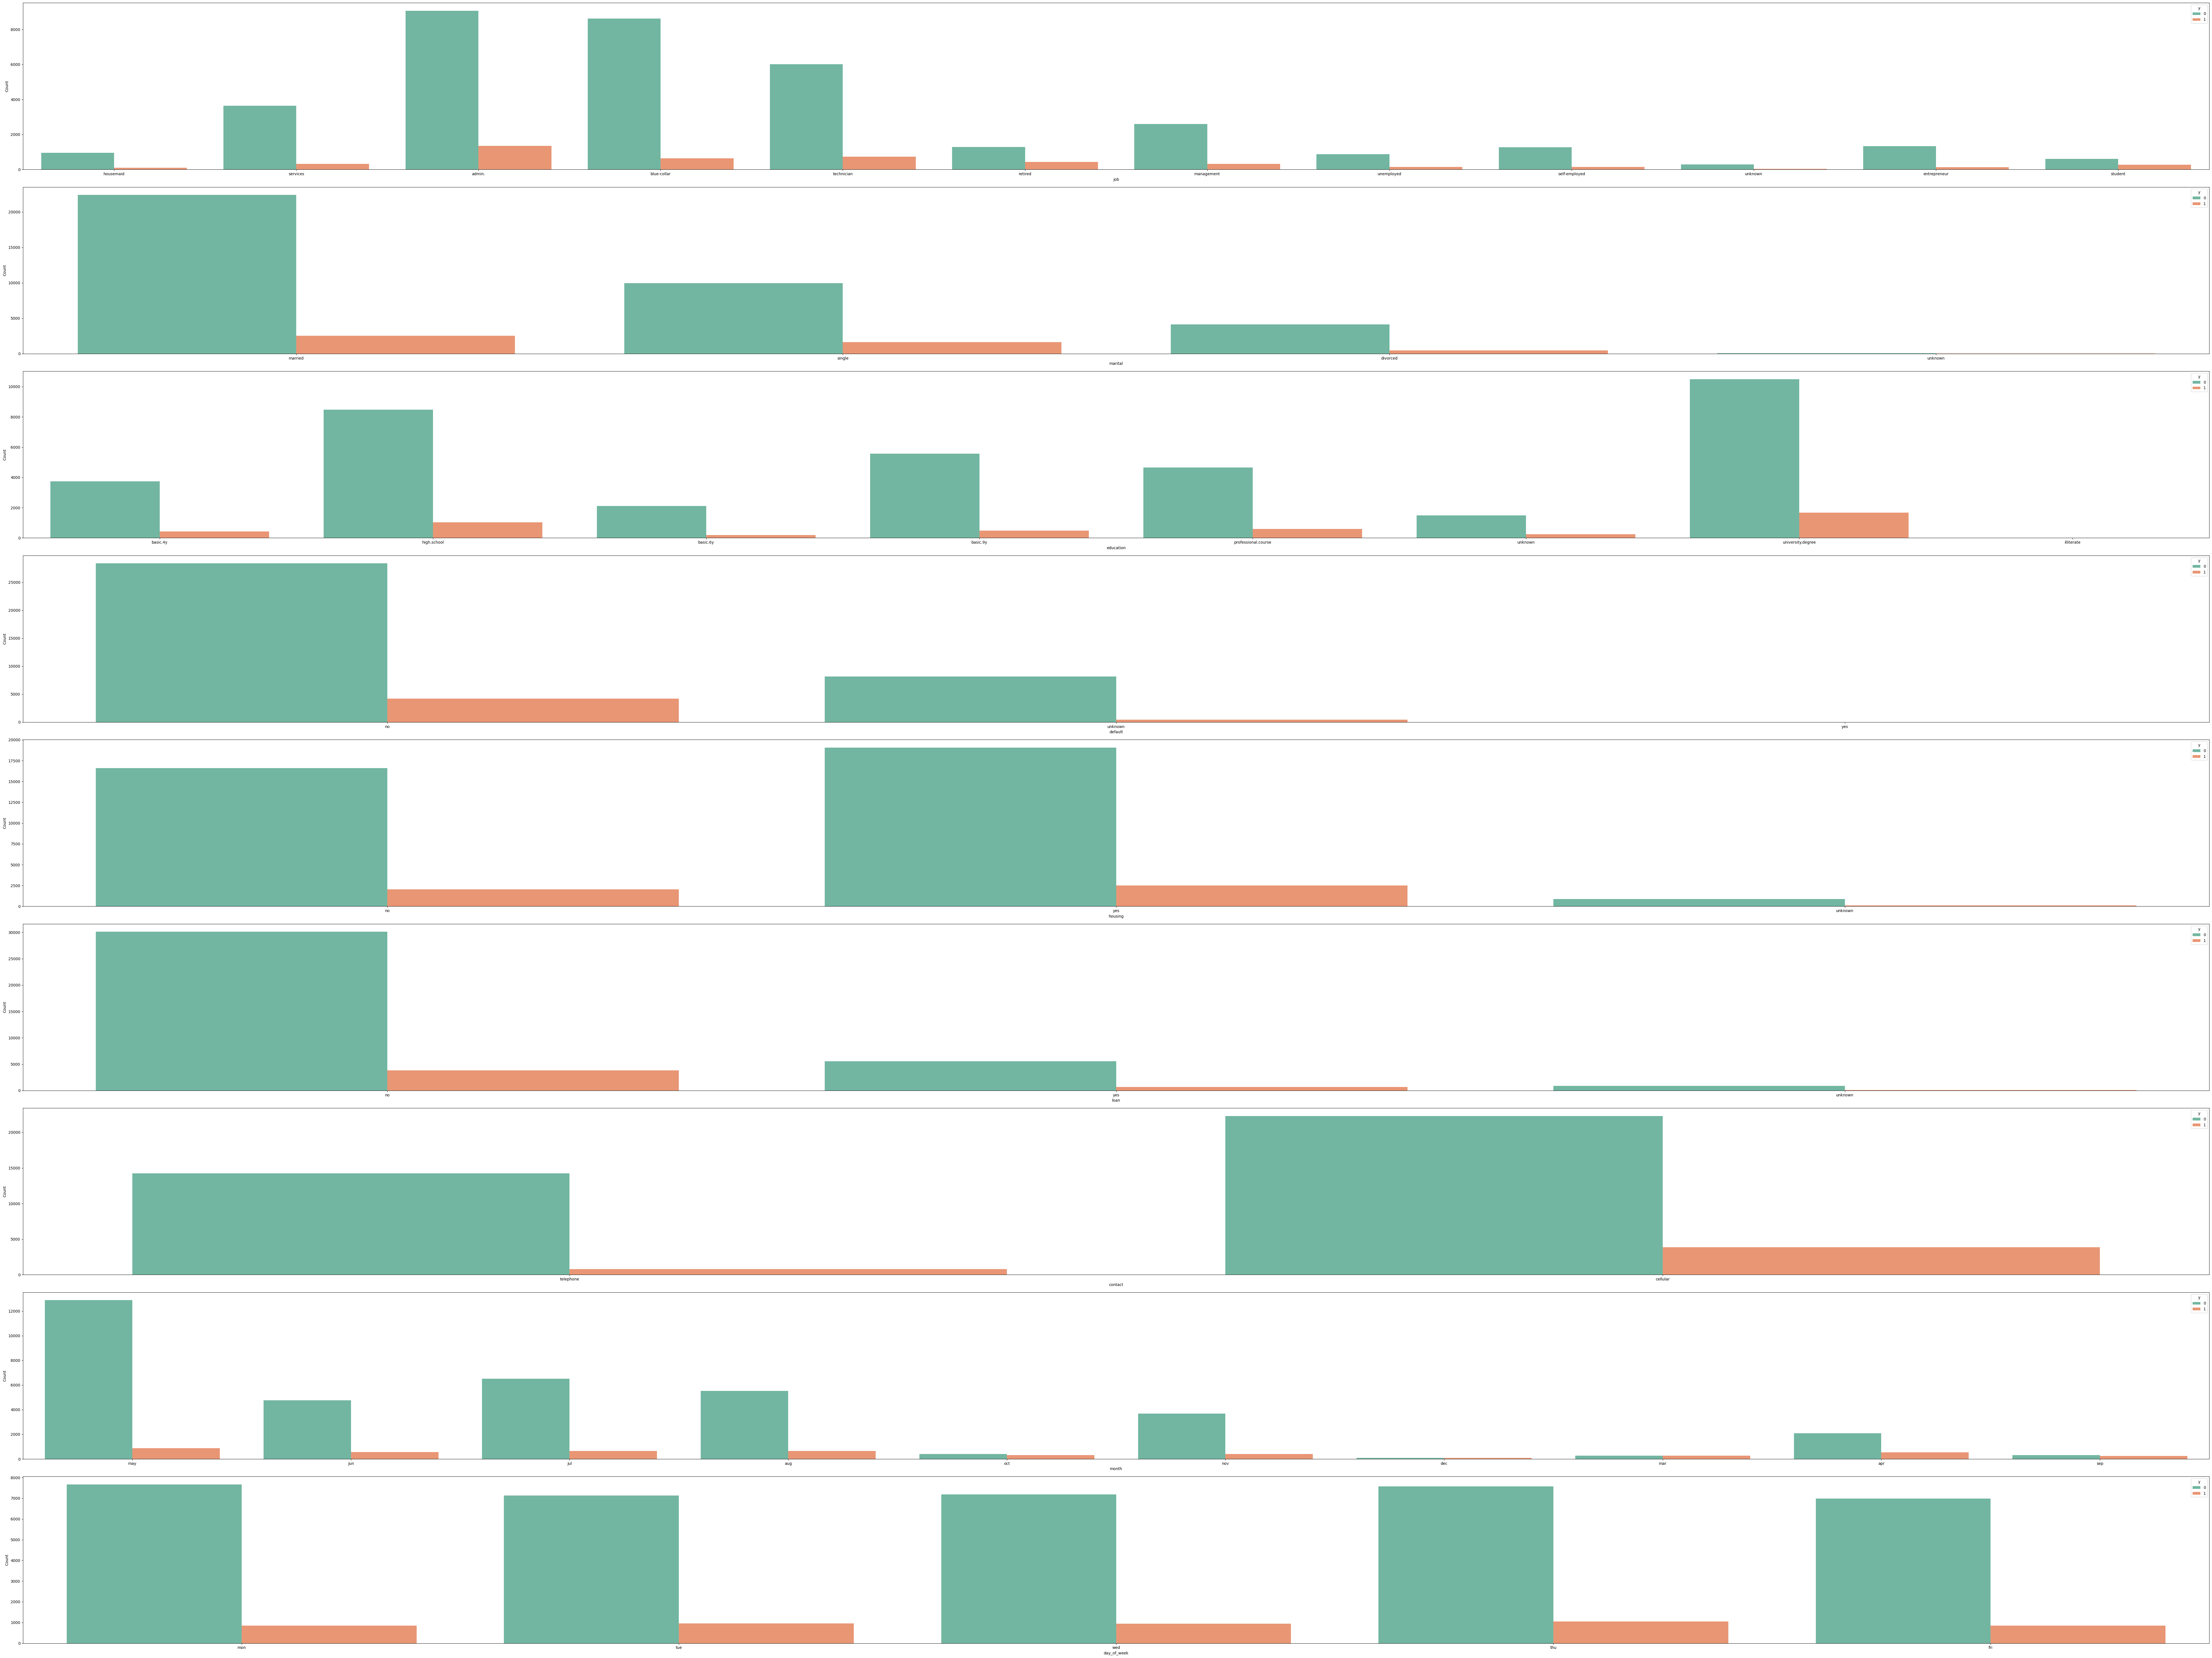

In [20]:
# Create a figure with subplots for each feature
fig, axes = plt.subplots(nrows=len(features_to_plot), figsize=(80, 60))

# Iterate over each feature and generate the bar plot
for i, feature in enumerate(features_to_plot):
    ax = axes[i] if len(features_to_plot) > 1 else axes
    sns.countplot(data=df, x=feature, hue='y', ax=ax, palette='Set2')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

With these new barplots we can represent how our variables are distributed at source in a better way. From the occurrence of each of the subcategories of the variables, as well as whether these individuals take value 0 or 1 in the target variable "y", to the occurrence of each of the subcategories of the variables, as well as whether these individuals take value 0 or 1 in the target variable "y".

**We start evaluating the proposed models:**


### LOGISTIC REGRESSION:  
#### Linear regression method for binary classification problems

 We create and train the logistic regression model

In [21]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression()

We make the predictions on the test partition:

In [22]:
y_pred_lr = model_lr.predict(X_test)

We evaluate the model obtained:

In [23]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)
print("Accuracy:", accuracy_lr)
print("Classification Report:\n", report_lr)

Accuracy: 0.8899679518306303
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      9137
           1       0.54      0.16      0.25      1160

    accuracy                           0.89     10297
   macro avg       0.72      0.57      0.59     10297
weighted avg       0.86      0.89      0.86     10297



We illustrate the results obtained by drawaing the ROC curve and the confusion matrix:

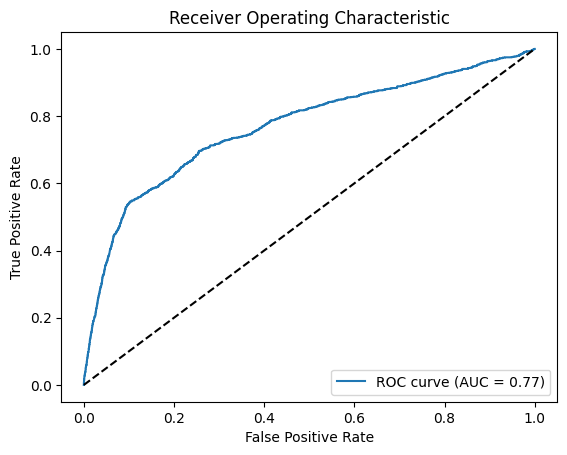

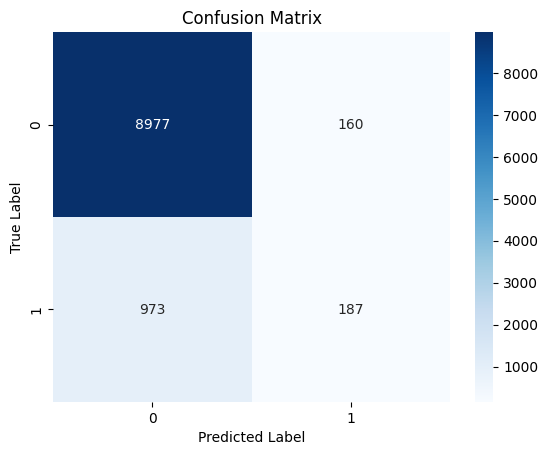

In [24]:
# Generate ROC curve and calculate AUC
y_pred_prob_lr = model_lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_prob_lr)
auc_lr = roc_auc_score(y_test, y_pred_prob_lr)

# Plot ROC curve
plt.plot(fpr_lr, tpr_lr, label='ROC curve (AUC = {:.2f})'.format(auc_lr))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_lr = model_lr.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Visualize confusion matrix
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
fig_lr = plt.gcf()  # Obtener la figura actual
plt.show()

### KNN (K k nearest neighbours)

We choose the different parameters for gridSearch

In [25]:
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}

We create the classifier

In [26]:
knn = KNeighborsClassifier()


We create the GridSearch object

In [27]:
# refit true, to retrain with all data
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=3, refit=True, n_jobs=-1)

We make the model fit

In [28]:
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']})

In [29]:
print("Best hyperparameters:", grid_search_knn.best_params_)
print("Accuracy score:", grid_search_knn.best_score_)

Best hyperparameters: {'algorithm': 'kd_tree', 'n_neighbors': 9, 'weights': 'uniform'}
Accuracy score: 0.8912304554724676


Get the best model and its predictions

In [30]:
best_model_knn = grid_search_knn.best_estimator_
y_pred_knn = best_model_knn.predict(X_test)

Evaluate the best model over test partition

In [31]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn)
print("Best Parameters:", grid_search_knn.best_params_)
print("Accuracy:", accuracy_knn)
print("Classification Report:\n", report_knn)

Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 9, 'weights': 'uniform'}
Accuracy: 0.8872487132174419
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      9137
           1       0.50      0.20      0.29      1160

    accuracy                           0.89     10297
   macro avg       0.70      0.59      0.61     10297
weighted avg       0.86      0.89      0.87     10297



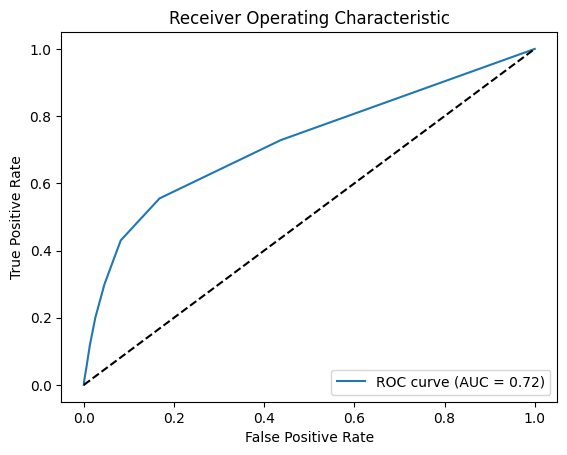

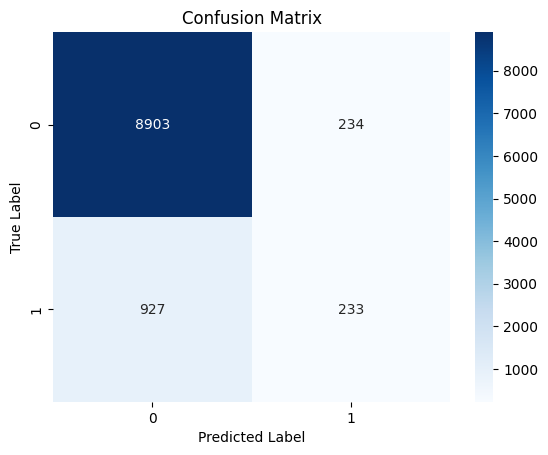

In [32]:
# Generate ROC curve and calculate AUC
y_pred_prob_knn = best_model_knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_prob_knn)
auc_knn = roc_auc_score(y_test, y_pred_prob_knn)

# Plot ROC curve
plt.plot(fpr_knn, tpr_knn, label='ROC curve (AUC = {:.2f})'.format(auc_knn))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_knn = best_model_knn.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Visualize confusion matrix
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### CLASSIFICATION TREES

We choose the different parameters for gridSearch

In [33]:
param_grid_ct = {'max_depth': [3, 5, 7, 9, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

We create the model classifier

In [34]:
model_ct = DecisionTreeClassifier(random_state=random_seed)

We create the GridSearch object

In [35]:
grid_search_ct = GridSearchCV(model_ct, param_grid_ct, cv=3, n_jobs=-1)

We make the model fit

In [36]:
grid_search_ct.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=14), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

We obtain and store the best model and the prediction

In [37]:
best_model_ct = grid_search_ct.best_estimator_
y_pred_ct = best_model_ct.predict(X_test)

Evaluate the best model

In [38]:
accuracy_ct = accuracy_score(y_test, y_pred_ct)
report_ct = classification_report(y_test, y_pred_ct)
print("Best Parameters:", grid_search_ct.best_params_)
print("Accuracy:", accuracy_ct)
print("Classification Report:\n", report_ct)

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.8909391084781976
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      9137
           1       0.53      0.27      0.36      1160

    accuracy                           0.89     10297
   macro avg       0.72      0.62      0.65     10297
weighted avg       0.87      0.89      0.87     10297



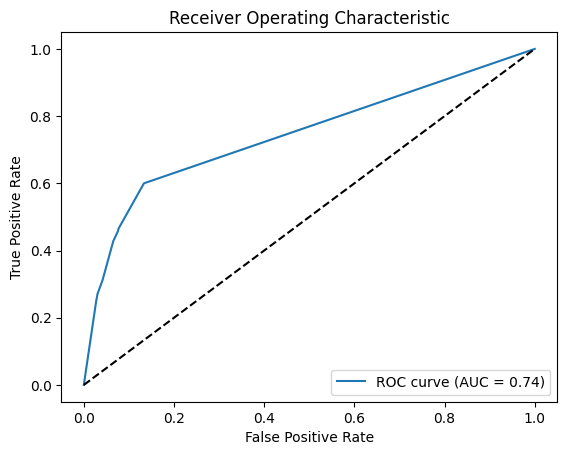

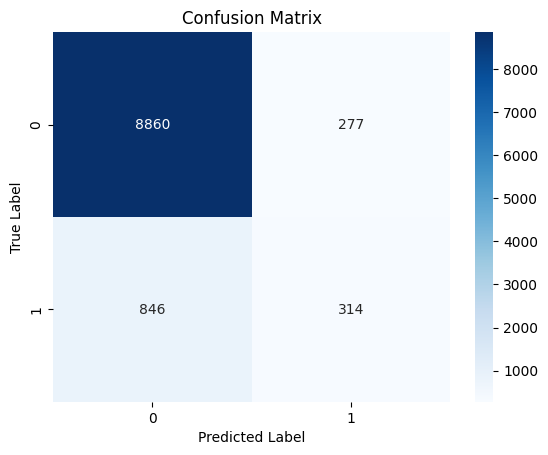

In [39]:
# Generate ROC curve and calculate AUC
y_pred_prob_ct = best_model_ct.predict_proba(X_test)[:, 1]
fpr_ct, tpr_ct, thresholds_ct = roc_curve(y_test, y_pred_prob_ct)
auc_ct = roc_auc_score(y_test, y_pred_prob_ct)

# Plot ROC curve
plt.plot(fpr_ct, tpr_ct, label='ROC curve (AUC = {:.2f})'.format(auc_ct))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_ct = best_model_ct.predict(X_test)
cm_ct = confusion_matrix(y_test, y_pred_ct)

# Visualize confusion matrix
sns.heatmap(cm_ct, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### RANDOM FOREST

We choose the different parameters for gridSearch

In [40]:
param_grid_rf = {"n_estimators": [50, 100, 200],
              "max_depth": [None, 5, 10],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 2, 4]}

We create the classifier

In [41]:
rfc = RandomForestClassifier(random_state=random_seed)

We create the GridSearch object

In [42]:
grid_search_rf = GridSearchCV(rfc, param_grid_rf, cv=3, n_jobs=-1)

We make the model fit

In [43]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=14), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [44]:
print("Best hyperparameters:", grid_search_rf.best_params_)
print("Accuracy score:", grid_search_rf.best_score_)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy score: 0.8952769415039978


In [45]:
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)

In [46]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)
print("Best Parameters:", grid_search_rf.best_params_)
print("Accuracy:", accuracy_rf)
print("Classification Report:\n", report_rf)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.89501796639798
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      9137
           1       0.58      0.24      0.34      1160

    accuracy                           0.90     10297
   macro avg       0.75      0.61      0.64     10297
weighted avg       0.87      0.90      0.88     10297



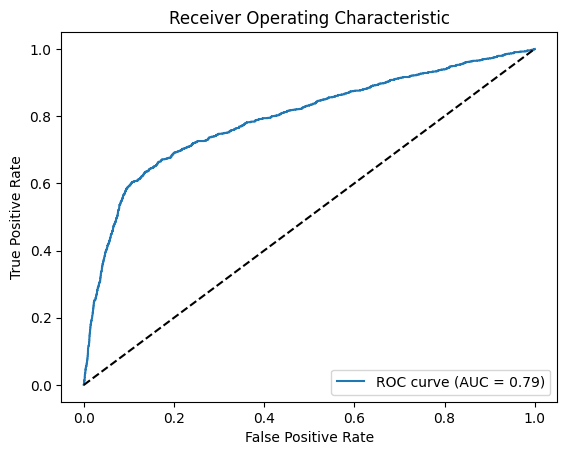

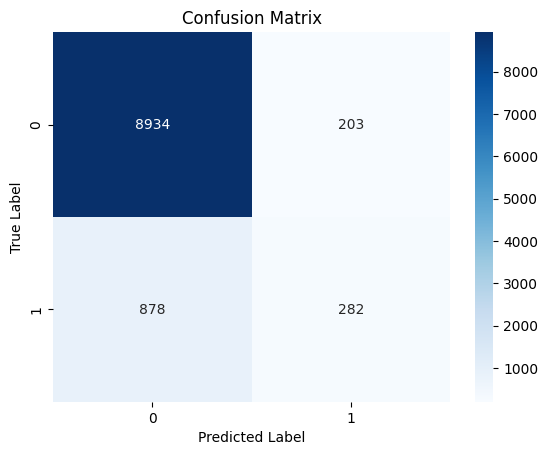

In [47]:
# Generate ROC curve and calculate AUC
y_pred_prob_rf = best_model_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

# Plot ROC curve
plt.plot(fpr_rf, tpr_rf, label='ROC curve (AUC = {:.2f})'.format(auc_rf))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_rf = best_model_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualize confusion matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVM (Support Vector Machine)

In [48]:
param_grid_svm = {"C": [0.1, 0.25, 0.5, 0.75, 1, 2],
              "kernel": ["linear", "poly", "rbf", "sigmoid"],
              "gamma": ["scale", "auto"]}

In [49]:
svm = SVC()

In [50]:
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=3, n_jobs=-1)

In [51]:
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.25, 0.5, 0.75, 1, 2],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [52]:
print("Best hyperparameters:", grid_search_svm.best_params_)
print("Accuracy score:", grid_search_svm.best_score_)

Best hyperparameters: {'C': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy score: 0.8944029005211874


In [53]:
best_model_svm = grid_search_svm.best_estimator_
y_pred_svm = best_model_svm.predict(X_test)

In [54]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)
print("Best Parameters:", grid_search_svm.best_params_)
print("Accuracy:", accuracy_svm)
print("Classification Report:\n", report_svm)

Best Parameters: {'C': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.8927843061085753
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      9137
           1       0.58      0.17      0.27      1160

    accuracy                           0.89     10297
   macro avg       0.74      0.58      0.60     10297
weighted avg       0.87      0.89      0.87     10297



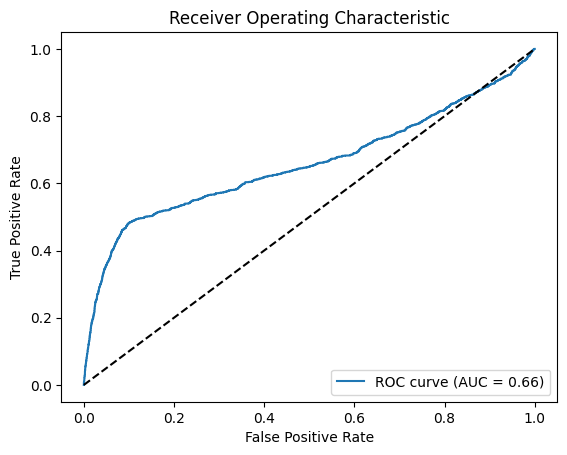

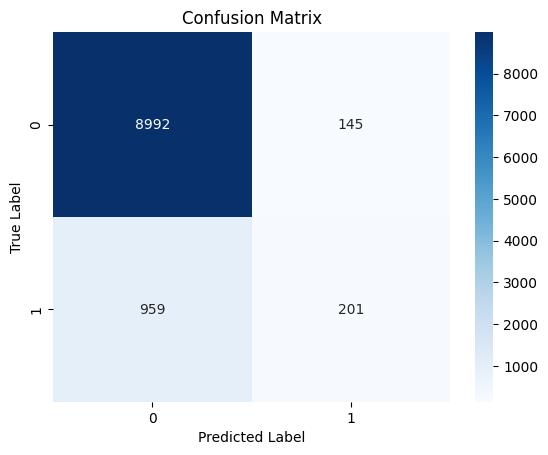

In [55]:
# Generate decision scores
y_pred_scores_svm = best_model_svm.decision_function(X_test)

# Calculate FPR, TPR, and AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_scores_svm)
auc_svm = roc_auc_score(y_test, y_pred_scores_svm)

# Plot ROC curve
plt.plot(fpr_svm, tpr_svm, label='ROC curve (AUC = {:.2f})'.format(auc_svm))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_svm = best_model_svm.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Visualize confusion matrix
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### NEURAL NETWORK:

We start creating the model function

In [56]:
def create_model_nn(hidden_units=128):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the parameter grid
param_grid_nn = {
    'hidden_units': [64, 128, 256],
    'epochs': [10, 20, 30],
    'batch_size': [16, 32, 64]
}

# Create the model
model_nn = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model_nn)

# Perform grid search
grid_search_nn = GridSearchCV(model_nn, param_grid_nn, cv=3, n_jobs=-1)


In [57]:
grid_search_nn.fit(X_train, y_train)

# Get the best parameters
best_params_nn = grid_search_nn.best_params_
best_params_nn

Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/20
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
 257/1288 [====>.........................] - ETA: 5s - loss: 0.2883 - accuracy: 0.8925Epoch 2/10
Epoch 2/10
1288/1288 [==============================] - 7s 5ms/step - loss: 0.2860 - accuracy: 0.8922
Epoch 3/20
1288/1288 [==============================] - 7s 5ms/step - loss: 0.2900 - accuracy: 0.8936
Epoch 3/20
1288/1288 [==============================] - 7s 6ms/step - loss: 0.2904 - accuracy: 0.8924
Epoch 3/10
1288/1288 [==============================] - 7s 6ms/step - loss: 0.2921 - accuracy: 0.8905
Epoch 3/20
1288/1288 [==============================] - 7s 6ms/step - loss: 0.2847 - accuracy: 0.8942
Epoch 4/20
1288/1288 [==============================] - 7s 5ms/step - loss: 0.2893 - accuracy: 0.8941
Epoch 4/20
1288/1288 [==============================] - 7s 6ms/step - loss: 0.2889 - accuracy: 0.8922
Epoch 5/10
12

{'batch_size': 16, 'epochs': 10, 'hidden_units': 256}

In [58]:
best_model_nn = create_model_nn(best_params_nn['hidden_units'])
best_model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model_nn.fit(X_train, y_train, epochs=best_params_nn['epochs'], batch_size=best_params_nn['batch_size'])

Epoch 1/10
1931/1931 [==============================] - 8s 4ms/step - loss: 0.2979 - accuracy: 0.8898
Epoch 2/10
1931/1931 [==============================] - 7s 4ms/step - loss: 0.2891 - accuracy: 0.8935
Epoch 3/10
1931/1931 [==============================] - 7s 4ms/step - loss: 0.2872 - accuracy: 0.8931
Epoch 4/10
1931/1931 [==============================] - 8s 4ms/step - loss: 0.2860 - accuracy: 0.8943
Epoch 5/10
1931/1931 [==============================] - 8s 4ms/step - loss: 0.2853 - accuracy: 0.8935
Epoch 6/10
1931/1931 [==============================] - 7s 4ms/step - loss: 0.2846 - accuracy: 0.8931
Epoch 7/10
1931/1931 [==============================] - 8s 4ms/step - loss: 0.2838 - accuracy: 0.8940
Epoch 8/10
1931/1931 [==============================] - 8s 4ms/step - loss: 0.2825 - accuracy: 0.8953
Epoch 9/10
1931/1931 [==============================] - 8s 4ms/step - loss: 0.2824 - accuracy: 0.8951
Epoch 10/10
1931/1931 [==============================] - 7s 4ms/step - loss: 0.281

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob_nn = best_model_nn.predict(X_test)
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)

accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

print('Accuracy: %.2f' % (accuracy_nn*100))
print('Precision: %.2f' % (precision_nn*100))
print('Recall: %.2f' % (recall_nn*100))
print('F1-score: %.2f' % (f1_nn*100))

322/322 [==============================] - 1s 2ms/step
Accuracy: 89.21
Precision: 58.78
Recall: 14.14
F1-score: 22.79


In [60]:
print("Best Parameters: ", best_params_nn)

# Evaluate the model
print(f'Test Accuracy: {accuracy_nn*100:.2f}%')

Best Parameters:  {'batch_size': 16, 'epochs': 10, 'hidden_units': 256}
Test Accuracy: 89.21%


322/322 [==============================] - 1s 2ms/step


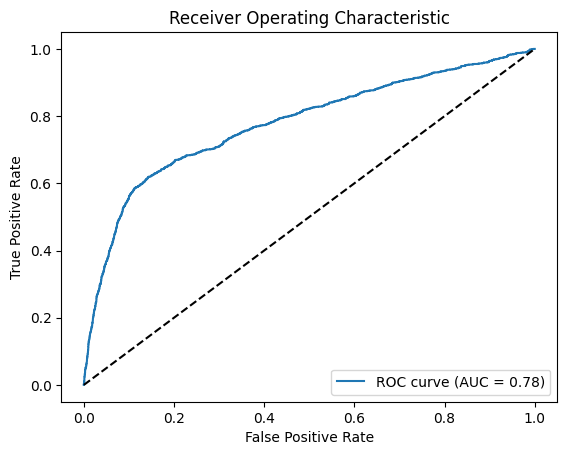

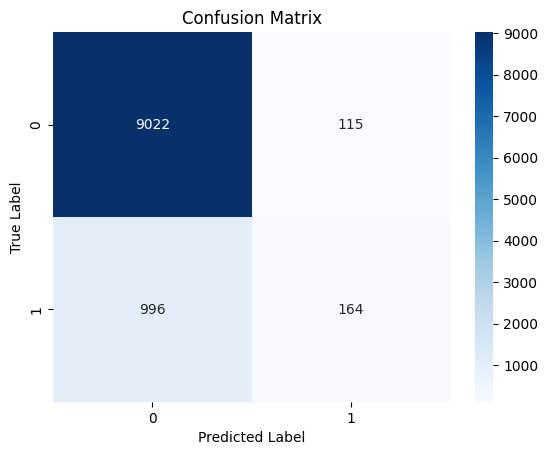

In [61]:
y_pred_prob_nn = best_model_nn.predict(X_test)

# Generate ROC curve and calculate AUC
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_prob_nn)
auc_nn = roc_auc_score(y_test, y_pred_prob_nn)

# Plot ROC curve
plt.plot(fpr_nn, tpr_nn, label='ROC curve (AUC = {:.2f})'.format(auc_nn))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Apply thresholds
umbral = 0.5
y_pred_discret_nn = np.where(y_pred_prob_nn >= umbral, 1, 0)

# Create confusion matrix
cm_nn = confusion_matrix(y_test, y_pred_discret_nn)

# Visualize confusion matrix
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### AdaBoost (Adaptative Boosting):

In [62]:
# Create the base estimator
base_estimator_ab = DecisionTreeClassifier()

# Create the AdaBoost classifier
ada_boost = AdaBoostClassifier(base_estimator=base_estimator_ab)

# Define the parameter grid for AdaBoost
param_grid_ab = {
    'n_estimators': [50, 100, 200], 
    'learning_rate': [0.1, 0.5, 1.0]  
}


# Perform grid search for AdaBoost
grid_search_ab = GridSearchCV(ada_boost, param_grid_ab, cv=3, n_jobs=-1)
grid_search_ab.fit(X_train, y_train)

# Get the best AdaBoost model and its performance
best_ada_boost = grid_search_ab.best_estimator_
best_params_ab = grid_search_ab.best_params_
best_score_ab = grid_search_ab.best_score_

# Train the best AdaBoost model with all data
best_ada_boost.fit(X_train, y_train)

# Evaluate the best AdaBoost model
test_accuracy_ab = best_ada_boost.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy_ab*100:.2f}%')

Test Accuracy: 85.31%


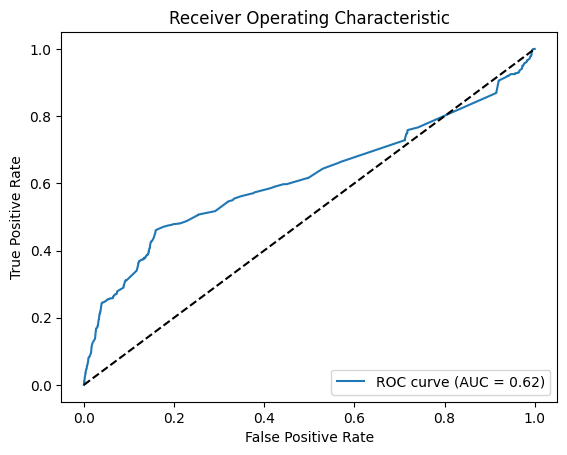

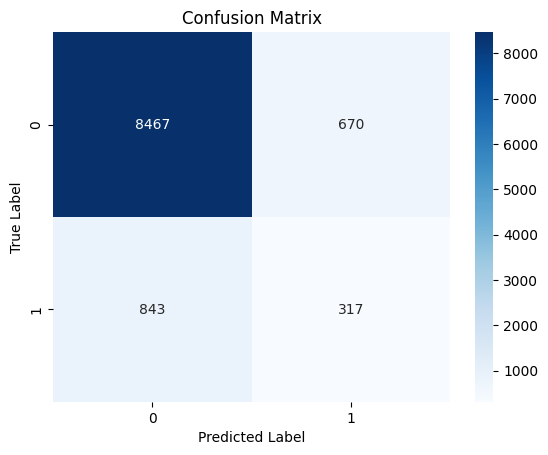

In [63]:
# Generate ROC curve and calculate AUC
y_pred_prob_ab = best_ada_boost.predict_proba(X_test)[:, 1]
fpr_ab, tpr_ab, thresholds_ab = roc_curve(y_test, y_pred_prob_ab)
auc_ab = roc_auc_score(y_test, y_pred_prob_ab)

# Plot ROC curve
plt.plot(fpr_ab, tpr_ab, label='ROC curve (AUC = {:.2f})'.format(auc_ab))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_ab = best_ada_boost.predict(X_test)
cm_ab = confusion_matrix(y_test, y_pred_ab)

# Visualize confusion matrix
sns.heatmap(cm_ab, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Gradient Boosting:

In [64]:
# Create the Gradient Boosting classifier
gradient_boosting = GradientBoostingClassifier()

# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],        
    'learning_rate': [0.1, 0.5, 1.0],     
    'max_depth': [3, 4, 5]                 
}

# Perform grid search for Gradient Boosting
grid_search_gb = GridSearchCV(gradient_boosting, param_grid_gb, cv=3, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Get the best Gradient Boosting model and its performance
best_gradient_boosting = grid_search_gb.best_estimator_
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

# Train the best Gradient Boosting model with all data
best_gradient_boosting.fit(X_train, y_train)

# Evaluate the best Gradient Boosting model
test_accuracy_gb = best_gradient_boosting.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy_gb*100:.2f}%')

Test Accuracy: 89.43%


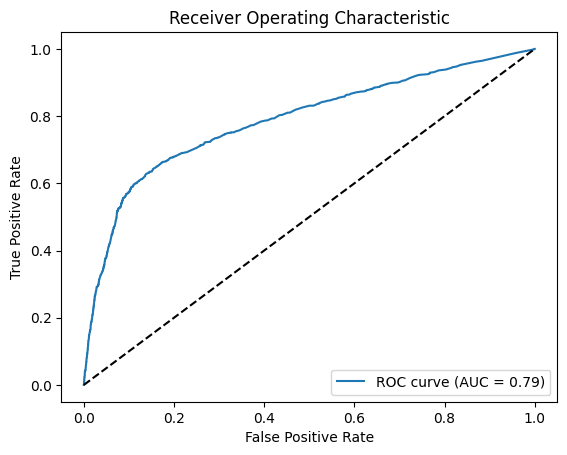

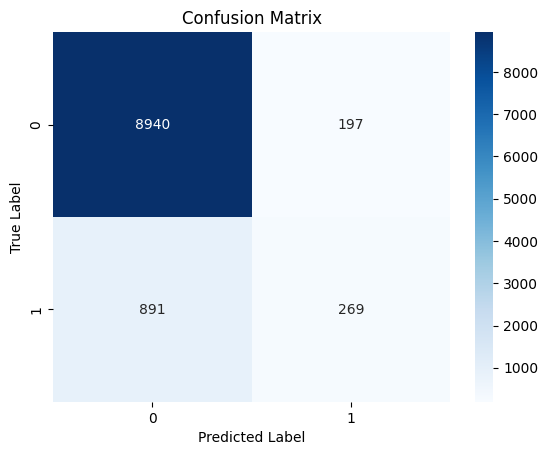

In [65]:
# Generate ROC curve and calculate AUC
y_pred_prob_gb = best_gradient_boosting.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_prob_gb)
auc_gb = roc_auc_score(y_test, y_pred_prob_gb)

# Plot ROC curve
plt.plot(fpr_gb, tpr_gb, label='ROC curve (AUC = {:.2f})'.format(auc_gb))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_gb = best_gradient_boosting.predict(X_test)
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Visualize confusion matrix
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## Dataset unbalance problem

By showing the ROC curve, the AUC value and the confusion matrix, we can see that, despite having a high accuracy, there is a problem with our models.

The data we have are unbalanced, since we have much more data from the "No" class than from the "Yes" class. This makes that our models do not learn well due to the unbalance. 

To fix it, we have different possible solutions: 

- **Penalize the majority class:** Since we learn more with it, by putting a penalty we could make the other class to be taken more into account. However, not all models allow us to make this modification. The logistic regression and the Random Forest implemented does allow us to do it by means of the parameter "class_weight='balanced'". Even so, these models are not the best performing, so it is not an effective measure for the whole analysis.



- **Try more complex ensemble methods** that work better for these types of unbalanced datasets. One of the possible implementations is to make use of the "StackingClassifier". 



- **Make use of subsampling and oversampling:** That is, if we remove records from the majority class, or synthetically add records from the minority class, we can try to reduce the unbalance and make it more balanced, thus improving the results of our models.



- **Analyze if there are variables that are not relevant in the dataset for most of our models and eliminate them:** By doing this, we can eliminate variables that always take similar values that are causing this unbalance and that do not contribute information to our models.


### OVERSAMPLING APPROACH (and penalizing the majority class if the model allows it)

Let's start by applying oversampling. For this we make use of the "imblearn" library and the SMOTE (Synthetic Minority Over-sampling Technique) function.

In [66]:
from imblearn.over_sampling import SMOTE

In [67]:
smote = SMOTE(k_neighbors = 5, random_state=random_seed)
X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

In [68]:
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train:",y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (30891, 14)
X_test shape: (10297, 14)
y_train: (30891,)
y_test shape: (10297,)


In [69]:
print("X_train shape:",X_train_os.shape)
print("X_test shape:",X_test.shape)
print("y_train:",y_train_os.shape)
print("y_test shape:", y_test.shape)

X_train shape: (54822, 14)
X_test shape: (10297, 14)
y_train: (54822,)
y_test shape: (10297,)


As we can see, more records have been added to the train partitions, from 30882 to 54804 records. It should be noted that it is only applied to the training set and not to the test set to avoid bias in the evaluation of the model.

In this way the model is allowed to more effectively learn the underlying characteristics of the minority classes without compromising the unbiased evaluation of the model on the test set.

### We retrain the most successful models with the new train partition.

#### LOGISTIC REGRESSION (WITH SMOTE):  
#### Linear regression method for binary classification problems

In addition, in this case we use the **penalization to the majority class, as this method allows it**

In [70]:
model_lr_smote = LogisticRegression(class_weight='balanced')
model_lr_smote.fit( X_train_os, y_train_os)

LogisticRegression(class_weight='balanced')

In [71]:
y_pred_lr_os = model_lr_smote.predict(X_test)

In [72]:
accuracy_lr_os = accuracy_score(y_test, y_pred_lr_os)
report_lr_os = classification_report(y_test, y_pred_lr_os)
print("Accuracy:", accuracy_lr_os)
print("Classification Report:\n", report_lr_os)

Accuracy: 0.7793532096727203
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.80      0.87      9137
           1       0.28      0.63      0.39      1160

    accuracy                           0.78     10297
   macro avg       0.61      0.71      0.63     10297
weighted avg       0.87      0.78      0.81     10297



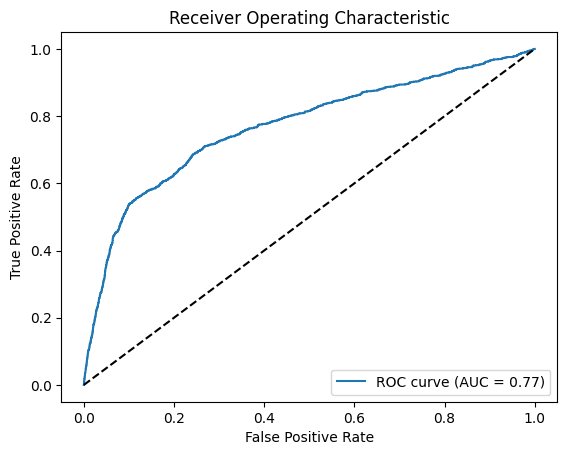

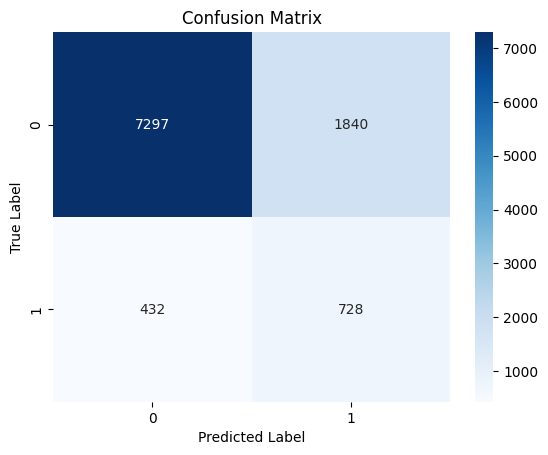

In [73]:
# Generate ROC curve and calculate AUC
y_pred_prob_lr_os = model_lr_smote.predict_proba(X_test)[:, 1]
fpr_lr_os, tpr_lr_os, thresholds_lr_os = roc_curve(y_test, y_pred_prob_lr_os)
auc_lr_os = roc_auc_score(y_test, y_pred_prob_lr_os)

# Plot ROC curve
plt.plot(fpr_lr_os, tpr_lr_os, label='ROC curve (AUC = {:.2f})'.format(auc_lr_os))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_lr_os = model_lr_smote.predict(X_test)
cm_lr_smote = confusion_matrix(y_test, y_pred_lr_os)

# Visualize confusion matrix
sns.heatmap(cm_lr_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
fig_cm_lr_smote = plt.gcf() 
plt.show()

#### COMPARISON OF THE CONFUSION MATRIX WITH THE 2 APPROACHES TO LOGISTIC REGRESSION

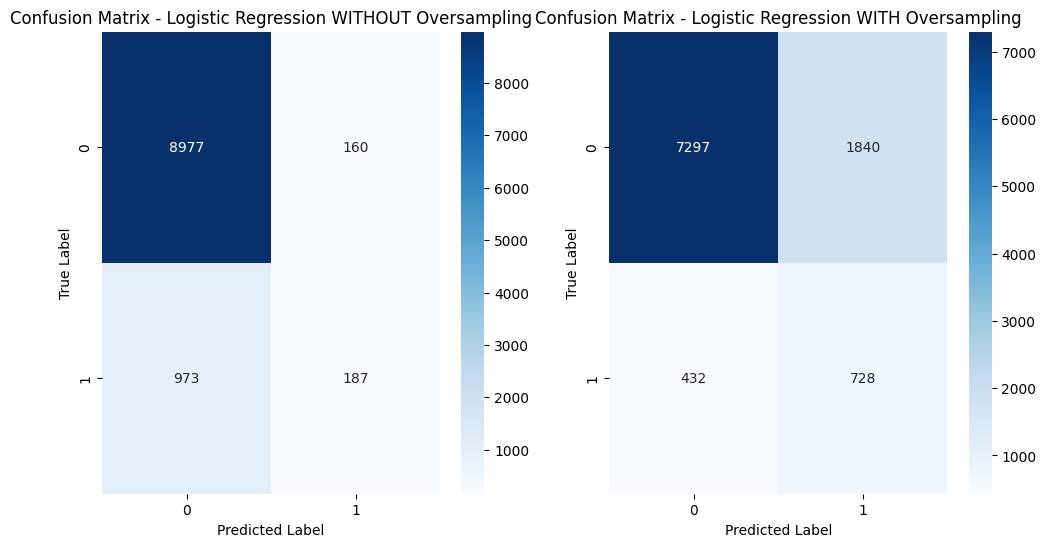

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize confusion matrix - Primera vez
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica 1
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Logistic Regression WITHOUT Oversampling')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Gráfica 2
sns.heatmap(cm_lr_smote, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Logistic Regression WITH Oversampling')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.show()

As we can see in the figure, by using oversampling and penalization, we obtain a model that classifies the minority class much better. It is true that the majority class is no longer classified as correctly as it was previously. However, we prefer the result to be the latter, since we no longer see the results of the unbalance.

#### KNN (WITH SMOTE):  

In [75]:
param_grid_knn_os= {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}

knn_os = KNeighborsClassifier()

# refit true, para que entrenemos con todos los datos
grid_search_knn_os = GridSearchCV(knn_os, param_grid_knn_os, cv=3, refit=True, n_jobs=-1)

grid_search_knn_os.fit(X_train_os, y_train_os)

print("Best hyperparameters:", grid_search_knn_os.best_params_)
print("Accuracy score:", grid_search_knn_os.best_score_)

best_model_knn_os = grid_search_knn_os.best_estimator_
y_pred_knn_os = best_model_knn_os.predict(X_test)

Best hyperparameters: {'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'distance'}
Accuracy score: 0.8809966801648973


In [76]:
accuracy_knn_os = accuracy_score(y_test, y_pred_knn_os)
report_knn_os = classification_report(y_test, y_pred_knn_os)
print("Best Parameters:", grid_search_knn_os.best_params_)
print("Accuracy:", accuracy_knn_os)
print("Classification Report:\n", report_knn_os)

Best Parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'distance'}
Accuracy: 0.811595610371953
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89      9137
           1       0.27      0.41      0.33      1160

    accuracy                           0.81     10297
   macro avg       0.60      0.64      0.61     10297
weighted avg       0.85      0.81      0.83     10297



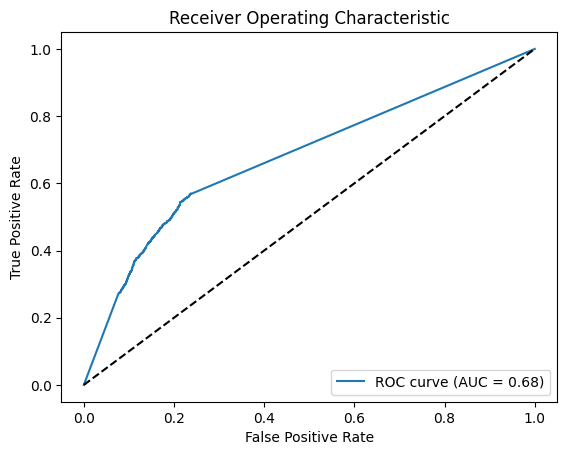

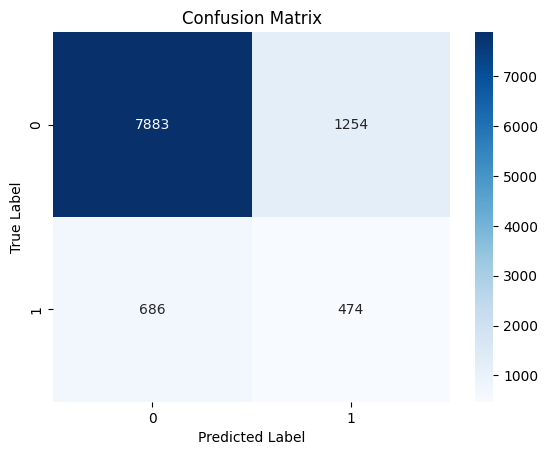

In [77]:
# Generate ROC curve and calculate AUC
y_pred_prob_knn_os = best_model_knn_os.predict_proba(X_test)[:, 1]
fpr_knn_os, tpr_knn_os, thresholds_knn_os = roc_curve(y_test, y_pred_prob_knn_os)
auc_knn_os = roc_auc_score(y_test, y_pred_prob_knn_os)

# Plot ROC curve
plt.plot(fpr_knn_os, tpr_knn_os, label='ROC curve (AUC = {:.2f})'.format(auc_knn_os))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_knn_os = best_model_knn_os.predict(X_test)
cm_knn_os = confusion_matrix(y_test, y_pred_knn_os)

# Visualize confusion matrix
sns.heatmap(cm_knn_os, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### COMPARISON OF THE CONFUSION MATRIX WITH THE 2 APPROACHES TO KNN:

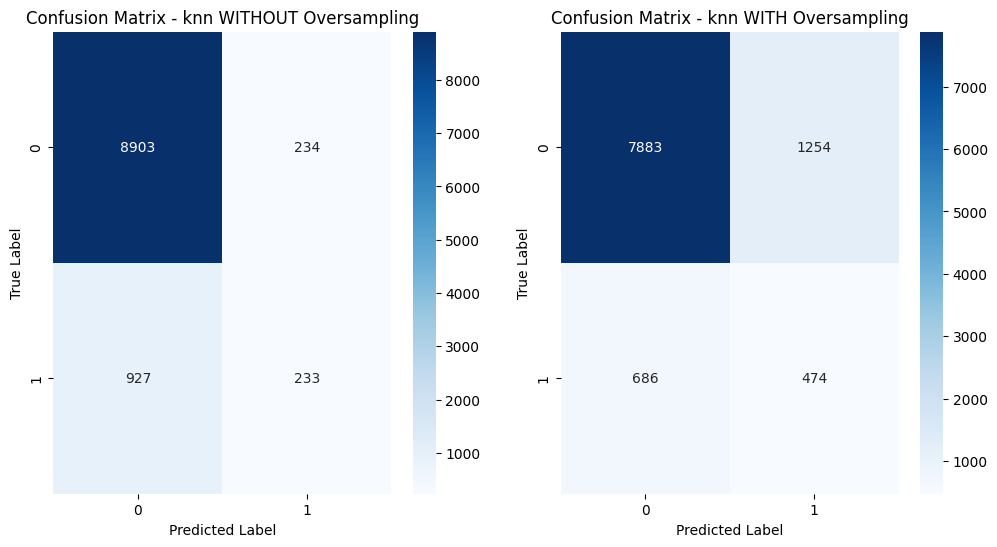

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize confusion matrix - Primera vez
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica 1
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - knn WITHOUT Oversampling')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Gráfica 2
sns.heatmap(cm_knn_os, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - knn WITH Oversampling')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.show()

#### CLASSIFICATION TREES (WITH SMOTE)

In [79]:
param_grid_ct_os = {'max_depth': [3, 5, 7, 9, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

model_ct_os = DecisionTreeClassifier(random_state=random_seed)
grid_search_ct_os = GridSearchCV(model_ct, param_grid_ct_os, cv=3, n_jobs=-1)
grid_search_ct_os.fit(X_train_os, y_train_os)

best_model_ct_os = grid_search_ct_os.best_estimator_
y_pred_ct_os = best_model_ct_os.predict(X_test)

accuracy_ct_os = accuracy_score(y_test, y_pred_ct_os)
report_ct_os = classification_report(y_test, y_pred_ct_os)
print("Best Parameters:", grid_search_ct_os.best_params_)
print("Accuracy:", accuracy_ct_os)
print("Classification Report:\n", report_ct_os)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 0.8485966786442654
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      9137
           1       0.31      0.28      0.29      1160

    accuracy                           0.85     10297
   macro avg       0.61      0.60      0.61     10297
weighted avg       0.84      0.85      0.85     10297



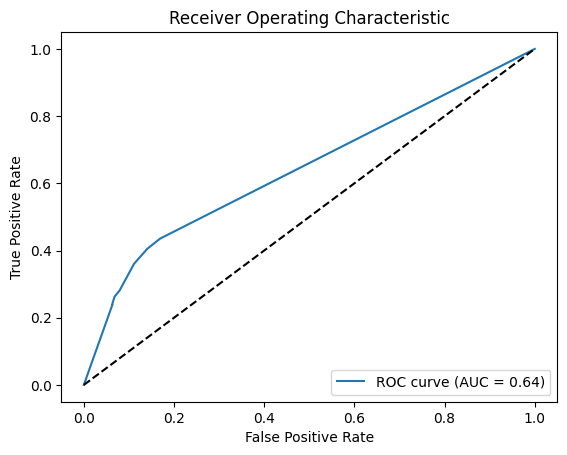

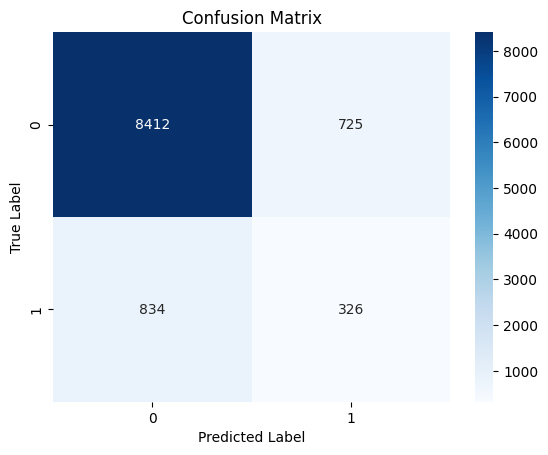

In [80]:
# Generate ROC curve and calculate AUC
y_pred_prob = best_model_ct_os.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred = best_model_ct_os.predict(X_test)
cm_ct_os = confusion_matrix(y_test, y_pred_ct_os)

# Visualize confusion matrix
sns.heatmap(cm_ct_os, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### COMPARISON OF THE CONFUSION MATRIX WITH THE 2 APPROACHES TO CT:

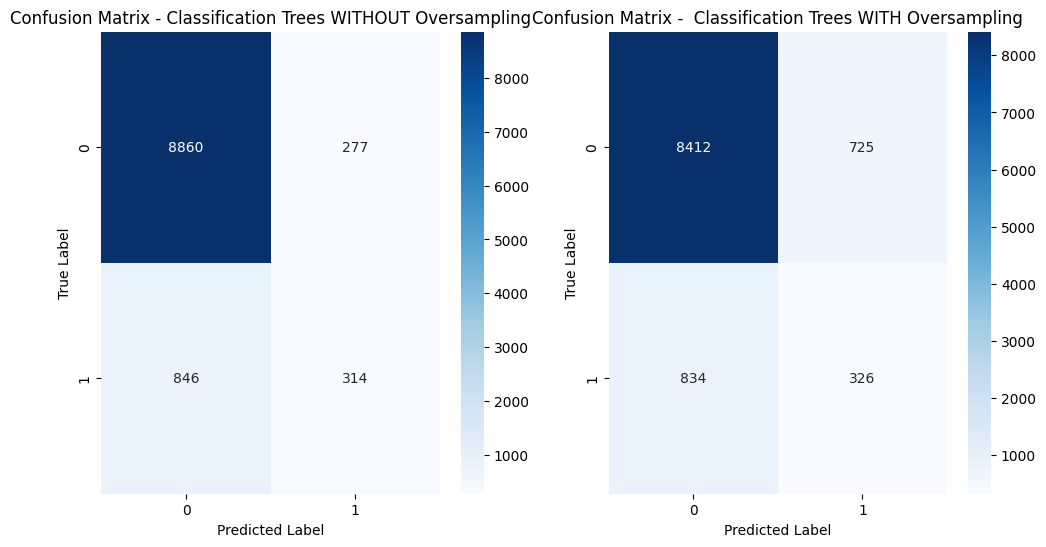

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize confusion matrix - Primera vez
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica 1
sns.heatmap(cm_ct, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Classification Trees WITHOUT Oversampling')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Gráfica 2
sns.heatmap(cm_ct_os, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix -  Classification Trees WITH Oversampling')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.show()

#### RANDOM FOREST (WITH SMOTE):  

In [82]:
param_grid_rf_os = {"n_estimators": [50, 100, 200],
              "max_depth": [None, 5, 10],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 2, 4]}
rfc_os = RandomForestClassifier(random_state=random_seed, class_weight='balanced')
grid_search_rf_os = GridSearchCV(rfc_os, param_grid_rf_os, cv=3, n_jobs=-1)
grid_search_rf_os.fit(X_train_os, y_train_os)

print("Best hyperparameters:", grid_search_rf_os.best_params_)
print("Accuracy score:", grid_search_rf_os.best_score_)

best_model_rf_os = grid_search_rf_os.best_estimator_
y_pred_rf_os = best_model_rf_os.predict(X_test)

accuracy_rf_os = accuracy_score(y_test, y_pred_rf_os)
report_rf_os = classification_report(y_test, y_pred_rf_os)
print("Best Parameters:", grid_search_rf_os.best_params_)
print("Accuracy:", accuracy_rf_os)
print("Classification Report:\n", report_rf_os)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy score: 0.9272372405238772
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.8765659900942022
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      9137
           1       0.44      0.38      0.41      1160

    accuracy                           0.88     10297
   macro avg       0.68      0.66      0.67     10297
weighted avg       0.87      0.88      0.87     10297



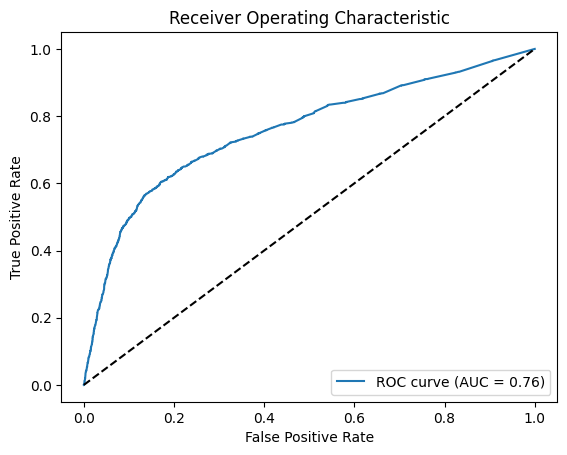

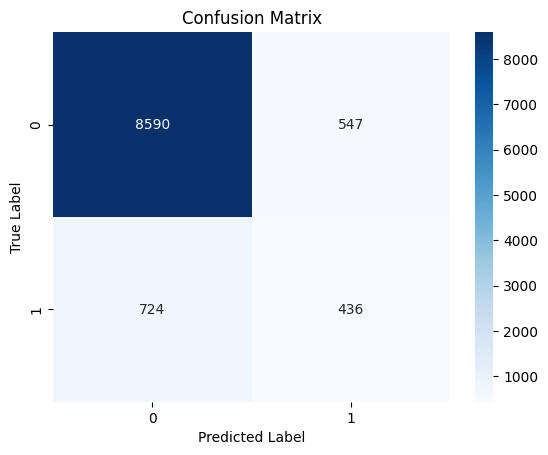

In [83]:
# Generate ROC curve and calculate AUC
y_pred_prob_rf_os = best_model_rf_os.predict_proba(X_test)[:, 1]
fpr_rf_os, tpr_rf_os, thresholds_rf_os = roc_curve(y_test, y_pred_prob_rf_os)
auc_rf_os = roc_auc_score(y_test, y_pred_prob_rf_os)

# Plot ROC curve
plt.plot(fpr_rf_os, tpr_rf_os, label='ROC curve (AUC = {:.2f})'.format(auc_rf_os))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_rf_os = best_model_rf_os.predict(X_test)
cm_rf_os = confusion_matrix(y_test, y_pred_rf_os)

# Visualize confusion matrix
sns.heatmap(cm_rf_os, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### COMPARISON OF THE CONFUSION MATRIX WITH THE 2 APPROACHES TO RANDOM FOREST:

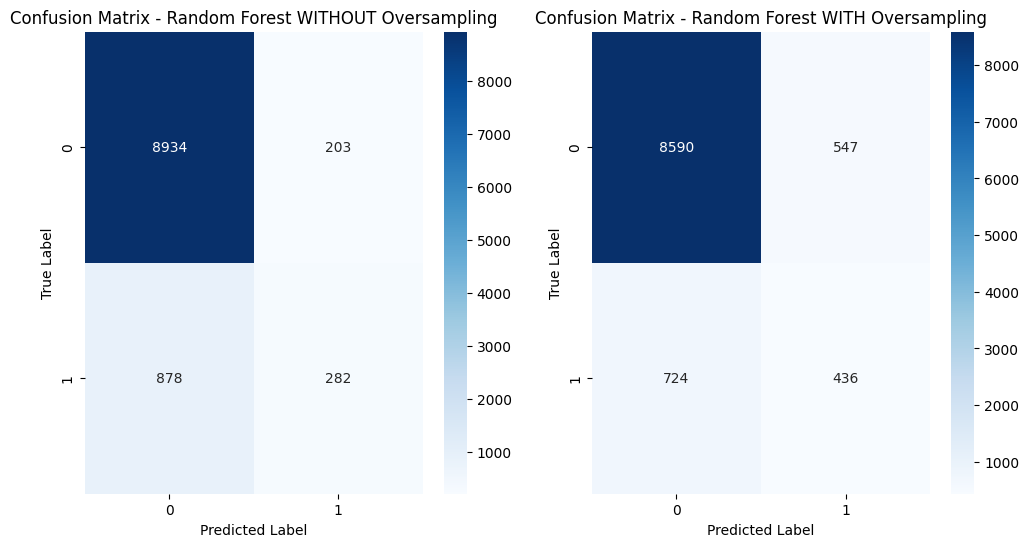

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize confusion matrix - Primera vez
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica 1
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Random Forest WITHOUT Oversampling')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Gráfica 2
sns.heatmap(cm_rf_os, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Random Forest WITH Oversampling')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.show()

#### GRADIENT BOOSTING (WITH SMOTE):  

In [85]:
# Create the Gradient Boosting classifier
gradient_boosting_smote = GradientBoostingClassifier()

# Define the parameter grid for Gradient Boosting
param_grid_gb_os = {
    'n_estimators': [50, 100, 200],        
    'learning_rate': [0.1, 0.5, 1.0],     
    'max_depth': [3, 4, 5]                 
}

# Perform grid search for Gradient Boosting
grid_search_gb_os = GridSearchCV(gradient_boosting_smote, param_grid_gb_os, cv=3, n_jobs=-1)
grid_search_gb_os.fit(X_train_os, y_train_os)

# Get the best Gradient Boosting model and its performance
best_gradient_boosting_smote = grid_search_gb_os.best_estimator_
best_params_gb_os = grid_search_gb_os.best_params_
best_score_gb_os = grid_search_gb_os.best_score_

# Train the best Gradient Boosting model with all data
best_gradient_boosting_smote.fit(X_train_os, y_train_os)

# Evaluate the best Gradient Boosting model
test_accuracy_gb_os = best_gradient_boosting_smote.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy_gb_os*100:.2f}%')

Test Accuracy: 88.21%


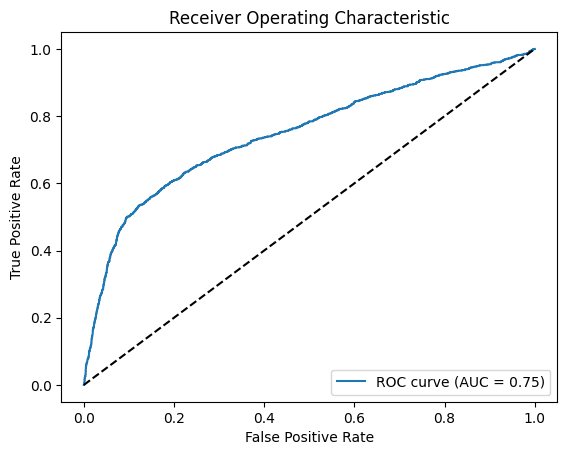

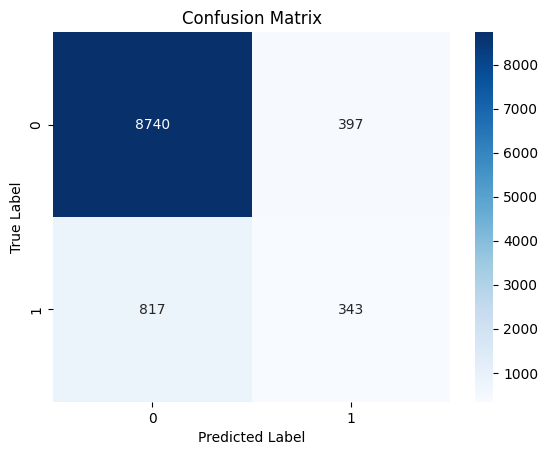

In [86]:
# Generate ROC curve and calculate AUC
y_pred_prob_gb_os = best_gradient_boosting_smote.predict_proba(X_test)[:, 1]
fpr_gb_os, tpr_gb_os, thresholds_gb_os = roc_curve(y_test, y_pred_prob_gb_os)
auc_gb_os = roc_auc_score(y_test, y_pred_prob_gb_os)

# Plot ROC curve
plt.plot(fpr_gb_os, tpr_gb_os, label='ROC curve (AUC = {:.2f})'.format(auc_gb_os))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_gb_os = best_gradient_boosting_smote.predict(X_test)
cm_gb_smote = confusion_matrix(y_test, y_pred_gb_os)

# Visualize confusion matrix
sns.heatmap(cm_gb_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### COMPARISON OF THE CONFUSION MATRIX WITH THE 2 APPROACHES TO GRADIENT BOOSTING:

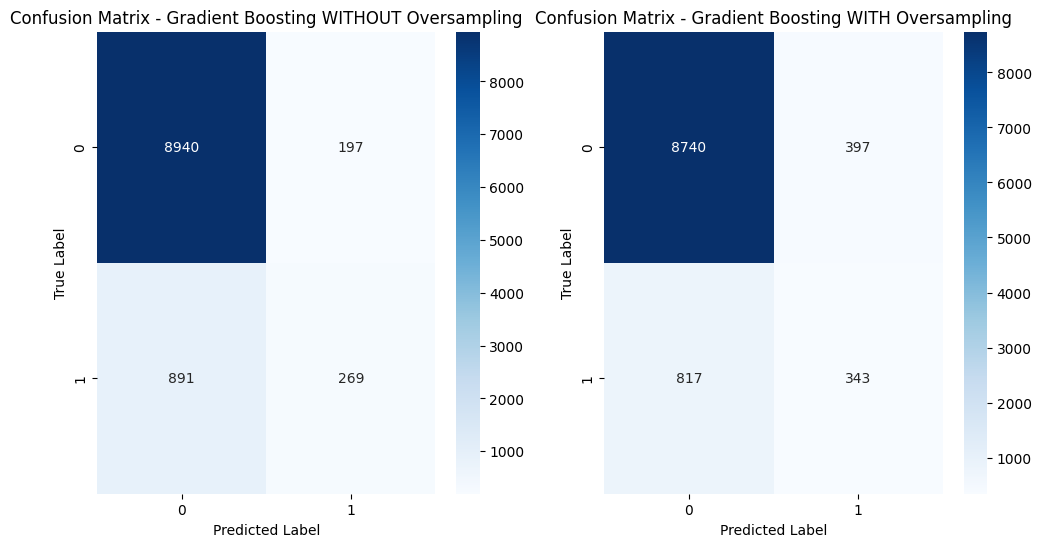

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize confusion matrix - Primera vez
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica 1
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Gradient Boosting WITHOUT Oversampling')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Gráfica 2
sns.heatmap(cm_gb_smote, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Gradient Boosting WITH Oversampling')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.show()

As we can see in both confusion matrices, the inclusion of oversampling improves the predictions. However, the improvement obtained with Logistic regression is better than with Gradient Boosting. Therefore, although without oversampling we would choose Gradient Boosting as the best model, using oversampling we choose logistic regression as the best model between these two.

#### NEURAL NETWORK (WITH SMOTE):  

In [88]:
def create_model_nn(hidden_units=128):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=X_train_os.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Define the parameter gridB
param_grid_nn_os = {
    'hidden_units': [64, 128, 256],
    'epochs': [10, 20, 30],
    'batch_size': [16, 32, 64]
}

# Create the model
model_nn_os = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model_nn)

# Perform grid search
grid_search_nn_os = GridSearchCV(model_nn_os, param_grid_nn_os, cv=3, n_jobs=-1)
grid_search_nn_os.fit(X_train_os, y_train_os)

# Get the best parameters
best_params_nn_os = grid_search_nn_os.best_params_
best_params_nn_os

Epoch 1/10
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/10
Epoch 1/10
Epoch 1/20
Epoch 1/20
2285/2285 [==============================] - 14s 6ms/step - loss: 0.5067 - accuracy: 0.7247
Epoch 2/10
2285/2285 [==============================] - 15s 6ms/step - loss: 0.5538 - accuracy: 0.7191
Epoch 2/10
2285/2285 [==============================] - 16s 6ms/step - loss: 0.5526 - accuracy: 0.7220
Epoch 2/10
2285/2285 [==============================] - 17s 6ms/step - loss: 0.5079 - accuracy: 0.7251
Epoch 2/20
2285/2285 [==============================] - 13s 6ms/step - loss: 0.5405 - accuracy: 0.7291
Epoch 3/10
2285/2285 [==============================] - 13s 6ms/step - loss: 0.5396 - accuracy: 0.7303
Epoch 3/20
2285/2285 [==============================] - 13s 6ms/step - loss: 0.4977 - accuracy: 0.7341
Epoch 3/20
2285/2285 [==============================] - 13s 6ms/step - loss: 0.4433 - accuracy: 0.8167
Epoch 3/10


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1714/1714 [==============================] - 7s 4ms/step - loss: 0.3186 - accuracy: 0.8571
Epoch 30/30
1024/1714 [================>.............] - ETA: 2s - loss: 0.3132 - accuracy: 0.8591

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1548/1714 [==========================>...] - ETA: 0s - loss: 0.3140 - accuracy: 0.8596

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


1714/1714 [==============================] - 6s 4ms/step - loss: 0.3152 - accuracy: 0.8587


{'batch_size': 32, 'epochs': 30, 'hidden_units': 256}

In [89]:
best_model_nn_os = create_model_nn(best_params_nn_os['hidden_units'])
best_model_nn_os.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model_nn_os.fit(X_train, y_train, epochs=best_params_nn_os['epochs'], batch_size=best_params_nn_os['batch_size'])

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


626/966 [==================>...........] - ETA: 1s - loss: 0.3007 - accuracy: 0.8893

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


830/966 [========================>.....] - ETA: 0s - loss: 0.3004 - accuracy: 0.8893

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


966/966 [==============================] - 5s 4ms/step - loss: 0.2996 - accuracy: 0.8888
Epoch 2/30
 87/966 [=>............................] - ETA: 3s - loss: 0.2900 - accuracy: 0.8865

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


966/966 [==============================] - 4s 4ms/step - loss: 0.2880 - accuracy: 0.8935
Epoch 3/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2871 - accuracy: 0.8943
Epoch 4/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2858 - accuracy: 0.8940
Epoch 5/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2845 - accuracy: 0.8939
Epoch 6/30
686/966 [====================>.........] - ETA: 1s - loss: 0.2870 - accuracy: 0.8930

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


966/966 [==============================] - 4s 4ms/step - loss: 0.2840 - accuracy: 0.8947
Epoch 7/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2833 - accuracy: 0.8939
Epoch 8/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2829 - accuracy: 0.8953
Epoch 9/30
722/966 [=====================>........] - ETA: 1s - loss: 0.2824 - accuracy: 0.8965

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


966/966 [==============================] - 4s 4ms/step - loss: 0.2824 - accuracy: 0.8958
Epoch 10/30
357/966 [==========>...................] - ETA: 2s - loss: 0.2812 - accuracy: 0.8946

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


966/966 [==============================] - 4s 4ms/step - loss: 0.2814 - accuracy: 0.8945
Epoch 11/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2802 - accuracy: 0.8962
Epoch 12/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2798 - accuracy: 0.8963
Epoch 13/30
727/966 [=====================>........] - ETA: 0s - loss: 0.2806 - accuracy: 0.8951

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


966/966 [==============================] - 4s 4ms/step - loss: 0.2789 - accuracy: 0.8960
Epoch 14/30
 18/966 [..............................] - ETA: 2s - loss: 0.2437 - accuracy: 0.9045

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


966/966 [==============================] - 4s 4ms/step - loss: 0.2781 - accuracy: 0.8970
Epoch 15/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2771 - accuracy: 0.8973
Epoch 16/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2760 - accuracy: 0.8968
Epoch 17/30
368/966 [==========>...................] - ETA: 2s - loss: 0.2712 - accuracy: 0.8976

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


866/966 [=========================>....] - ETA: 0s - loss: 0.2741 - accuracy: 0.8974

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


966/966 [==============================] - 4s 4ms/step - loss: 0.2757 - accuracy: 0.8964
Epoch 18/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2741 - accuracy: 0.8975
Epoch 19/30
223/966 [=====>........................] - ETA: 2s - loss: 0.2711 - accuracy: 0.9004

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


966/966 [==============================] - 4s 4ms/step - loss: 0.2737 - accuracy: 0.8980
Epoch 20/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2725 - accuracy: 0.8984
Epoch 21/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2722 - accuracy: 0.8990
Epoch 22/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2713 - accuracy: 0.8985
Epoch 23/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2702 - accuracy: 0.8985
Epoch 24/30
940/966 [============================>.] - ETA: 0s - loss: 0.2690 - accuracy: 0.8998

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


966/966 [==============================] - 4s 4ms/step - loss: 0.2693 - accuracy: 0.8999
Epoch 25/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2686 - accuracy: 0.9008
Epoch 26/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2677 - accuracy: 0.9007
Epoch 27/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2674 - accuracy: 0.9013
Epoch 28/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2662 - accuracy: 0.9016
Epoch 29/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2655 - accuracy: 0.9026
Epoch 30/30
966/966 [==============================] - 4s 4ms/step - loss: 0.2649 - accuracy: 0.9026


In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob_nn_os = best_model_nn_os.predict(X_test)
y_pred_nn_os = (y_pred_prob_nn_os > 0.5).astype(int)

accuracy_nn_os = accuracy_score(y_test, y_pred_nn_os)
precision_nn_os = precision_score(y_test, y_pred_nn_os)
recall_nn_os = recall_score(y_test, y_pred_nn_os)
f1_nn_os = f1_score(y_test, y_pred_nn_os)

print('Accuracy: %.2f' % (accuracy_nn_os*100))
print('Precision: %.2f' % (precision_nn_os*100))
print('Recall: %.2f' % (recall_nn_os*100))
print('F1-score: %.2f' % (f1_nn_os*100))

322/322 [==============================] - 1s 2ms/step
Accuracy: 88.79
Precision: 50.66
Recall: 19.83
F1-score: 28.50


In [91]:
print("Best Parameters: ", best_params_nn_os)

# Evaluate the model
print(f'Test Accuracy: {accuracy_nn_os*100:.2f}%')

Best Parameters:  {'batch_size': 32, 'epochs': 30, 'hidden_units': 256}
Test Accuracy: 88.79%


322/322 [==============================] - 1s 2ms/step


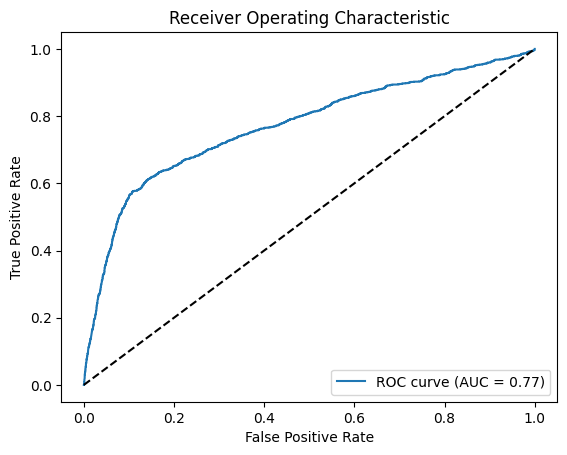

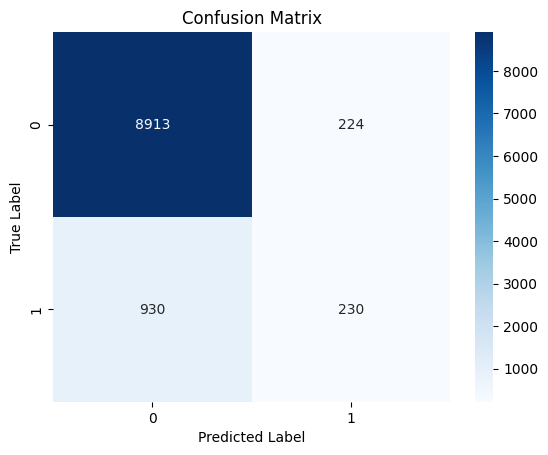

In [92]:
y_pred_prob_nn_os = best_model_nn_os.predict(X_test)

fpr_nn_os, tpr_nn_os, thresholds_nn_os = roc_curve(y_test, y_pred_prob_nn_os)
auc_nn_os = roc_auc_score(y_test, y_pred_prob_nn_os)

plt.plot(fpr_nn_os, tpr_nn_os, label='ROC curve (AUC = {:.2f})'.format(auc_nn_os))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


umbral = 0.5
y_pred_discret_nn_os = np.where(y_pred_prob_nn_os >= umbral, 1, 0)

cm_nn_os = confusion_matrix(y_test, y_pred_discret_nn_os)

sns.heatmap(cm_nn_os, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#### COMPARISON OF THE CONFUSION MATRIX WITH THE 2 APPROACHES TO GRADIENT NEURAL NETWORK:

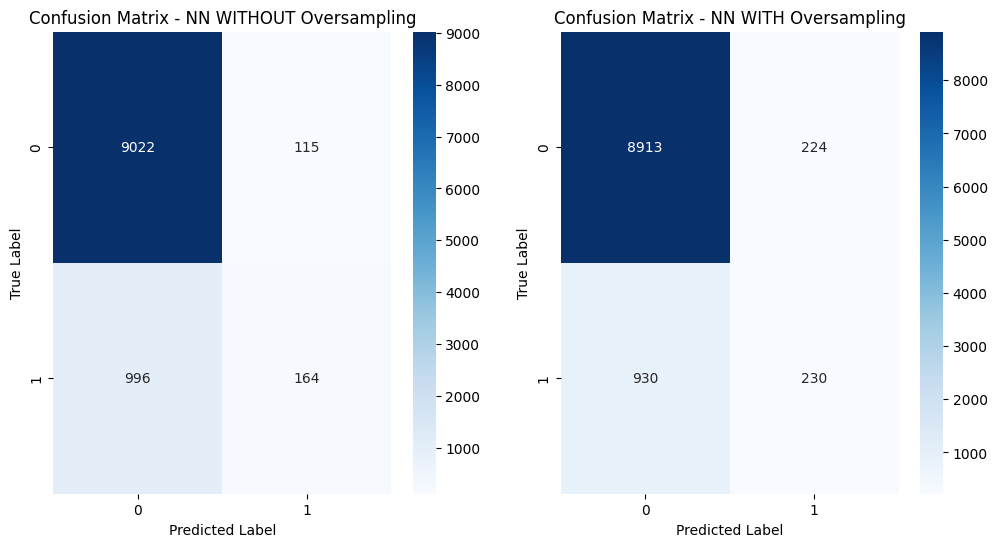

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize confusion matrix - Primera vez
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Graph 1
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - NN WITHOUT Oversampling')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Graph 2
sns.heatmap(cm_nn_os, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - NN WITH Oversampling')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.show()

### Stacked Generalization Ensemble

In order to solve the problem of the unbalanced dataset, we can also use different algorithms, as I stated before. One of the ones that behaves better is the Stacked Generalization Ensemble. For this algorithm, we will evaluate it with and without oversampling to analyse the impact of both solutions independently:

In [94]:
import pandas as pd
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


# Define base classifiers
rf_classifier = RandomForestClassifier(random_state=random_seed)
lr_classifier = LogisticRegression(random_state=random_seed)
knn_classifier = KNeighborsClassifier()

# Define the StackingClassifier
estimators = [
    ('rf', rf_classifier),
    ('lr', lr_classifier),
    ('knn', knn_classifier)
]

stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Define params grid
param_grid_sc = {
    'rf__n_estimators': [100, 200, 300],
    'knn__n_neighbors': [3, 5, 7],
    'final_estimator__C': [0.1, 1, 10]
}

# Hiperparms search using GridSearchCV
grid_search_sc = GridSearchCV(stacking_classifier, param_grid_sc, cv=3, n_jobs=-1)
grid_search_sc.fit(X_train, y_train)

# Get the best params
best_params_sc = grid_search_sc.best_params_
print("Mejores parámetros:", best_params_sc)

# Use the best model to predict
best_model_sc = grid_search_sc.best_estimator_
y_pred_sc = best_model_sc.predict(X_test)

# Get the accuracy
accuracy_sc = accuracy_score(y_test, y_pred_sc)
print("Precisión:", accuracy_sc)


Mejores parámetros: {'final_estimator__C': 1, 'knn__n_neighbors': 7, 'rf__n_estimators': 100}
Precisión: 0.8910362241429542


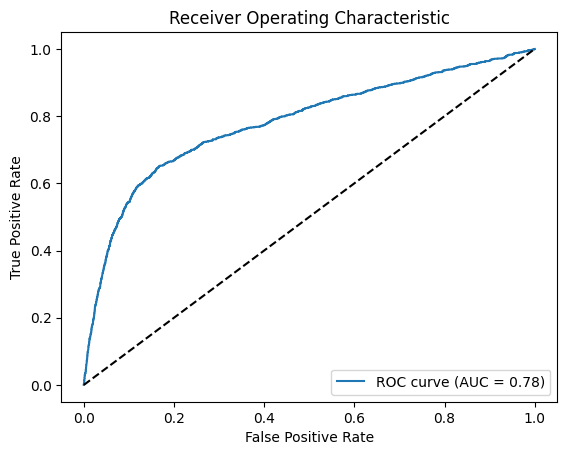

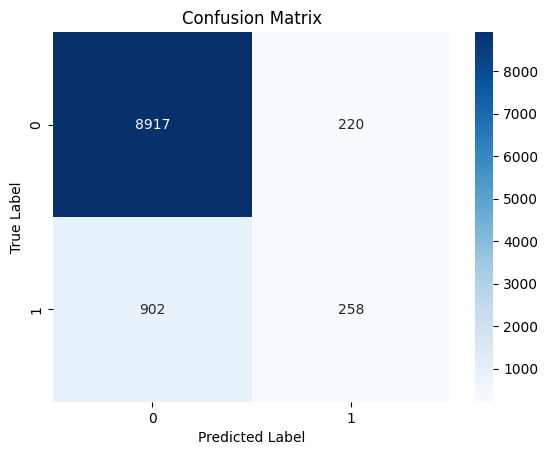

In [95]:
# Generate ROC curve and calculate AUC
y_pred_prob_sc = best_model_sc.predict_proba(X_test)[:, 1]
fpr_sc, tpr_sc, thresholds_sc = roc_curve(y_test, y_pred_prob_sc)
auc_sc = roc_auc_score(y_test, y_pred_prob_sc)

# Plot ROC curve
plt.plot(fpr_sc, tpr_sc, label='ROC curve (AUC = {:.2f})'.format(auc_sc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_sc = best_model_sc.predict(X_test)
cm_sc = confusion_matrix(y_test, y_pred_sc)

# Visualize confusion matrix
sns.heatmap(cm_sc, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Stacked Generalization Ensemble (with SMOTE)

In [96]:
import pandas as pd
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Define base classifiers
rf_classifier = RandomForestClassifier(random_state=random_seed)
lr_classifier = LogisticRegression(random_state=random_seed)
knn_classifier = KNeighborsClassifier()

# Definir el StackingClassifier
estimators = [
    ('rf', rf_classifier),
    ('lr', lr_classifier),
    ('knn', knn_classifier)
]

stacking_classifier_os = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=random_seed))

# Train StackingClassifier with the oversampled dataset
stacking_classifier_os.fit(X_train_os, y_train_os)

# Predict of test
y_pred_sc_os = stacking_classifier_os.predict(X_test)

# Get accuracy
accuracy_sc_os = accuracy_score(y_test, y_pred_sc_os)
print("Precisión:", accuracy_sc_os)


Precisión: 0.8678255802660969


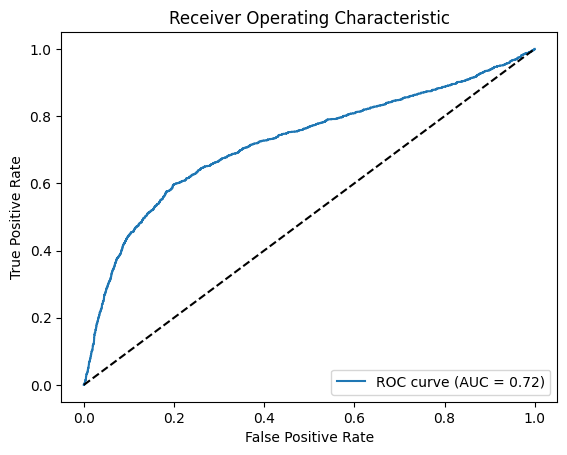

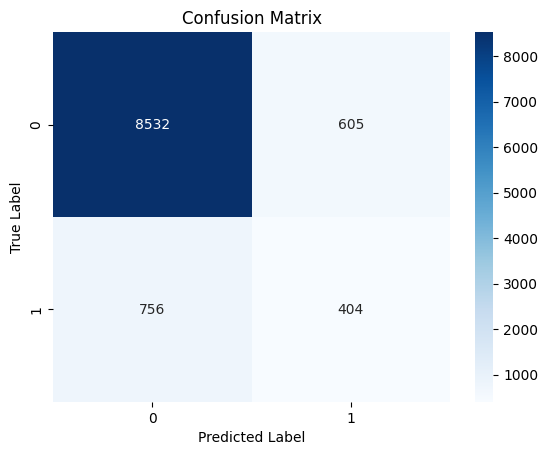

In [97]:
# Generate ROC curve and calculate AUC
y_pred_prob_sc_os = stacking_classifier_os.predict_proba(X_test)[:, 1]
fpr_sc_os, tpr_sc_os, thresholds_sc_os = roc_curve(y_test, y_pred_prob_sc_os)
auc_sc_os = roc_auc_score(y_test, y_pred_prob_sc_os)

# Plot ROC curve
plt.plot(fpr_sc_os, tpr_sc_os, label='ROC curve (AUC = {:.2f})'.format(auc_sc_os))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
y_pred_sc_os = stacking_classifier_os.predict(X_test)
cm_sc_os = confusion_matrix(y_test, y_pred_sc_os)

# Visualize confusion matrix
sns.heatmap(cm_sc_os, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

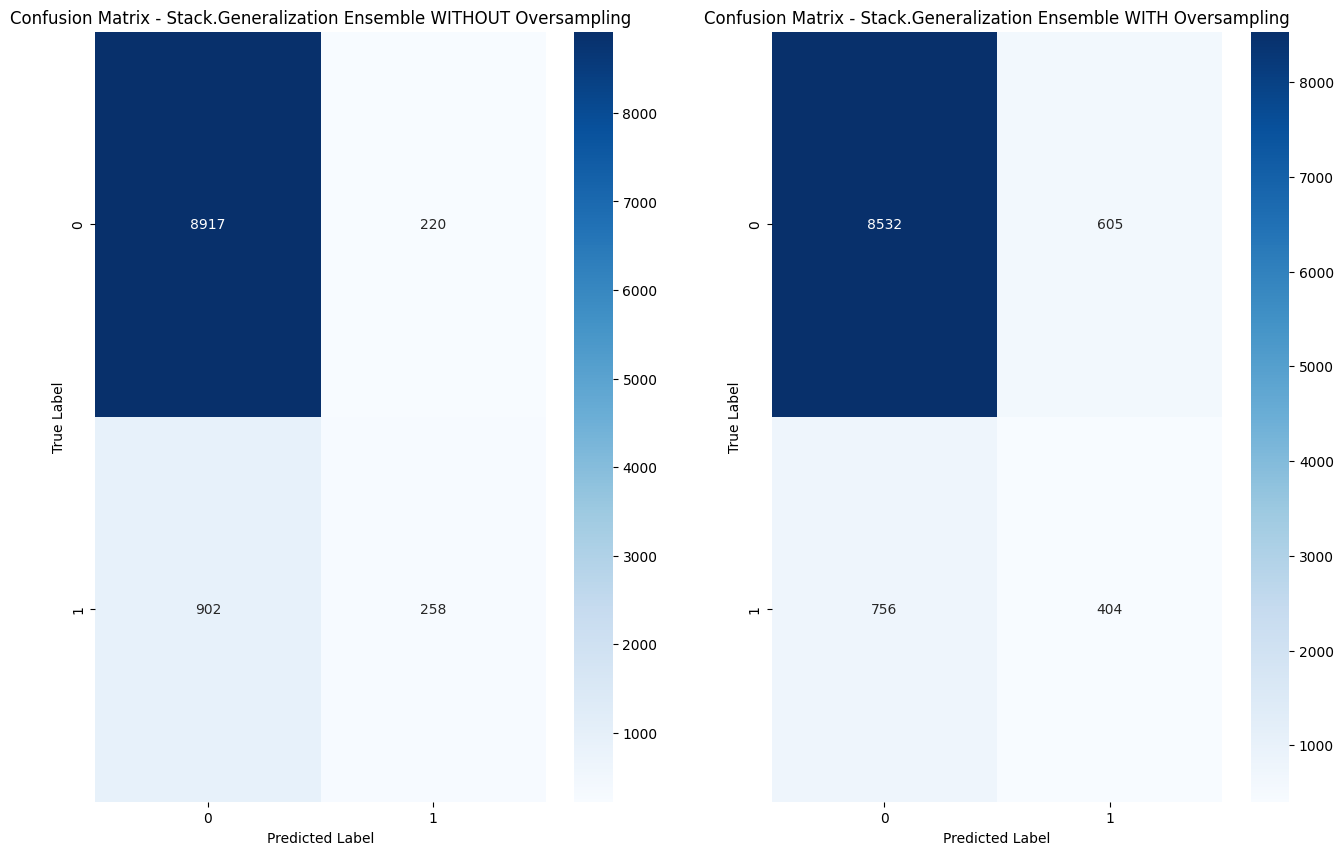

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize confusion matrix - Primera vez
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Graph 1
sns.heatmap(cm_sc, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Stack.Generalization Ensemble WITHOUT Oversampling')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Graph 2
sns.heatmap(cm_sc_os, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - Stack.Generalization Ensemble WITH Oversampling')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.show()

### ACCURACY AND AUC TABLE SUMMARY

In [126]:
import pandas as pd

# Define the variables with the models and the desired data
models = ['Logistic Regression', 'k-Nearest Neighbors(k-NN)', 'Support Vector Machines (SVM)', 'Classification Trees', 'Random Forest', 'Ada Boost', 'Gradient Boosting', 'Neural Networks (NN)', 'Stacked Generalization Ensemble']
accuracy = [accuracy_lr, accuracy_knn, accuracy_svm, accuracy_ct, accuracy_rf, test_accuracy_ab, test_accuracy_gb, accuracy_nn, accuracy_sc]
auc = [auc_lr, auc_knn, auc_svm, auc_ct, auc_rf, auc_ab, auc_gb, auc_nn, auc_sc]

# Create a dict
data_summary_no_smote = {
    'Model': models,
    'Accuracy': accuracy,
    'AUC':auc
}

# Create a DataFrame 
df_summary_no_smote = pd.DataFrame(data_summary_no_smote)

print(df_summary_no_smote)

                             Model  Accuracy       AUC
0              Logistic Regression  0.889968  0.768221
1        k-Nearest Neighbors(k-NN)  0.887249  0.722743
2    Support Vector Machines (SVM)  0.892784  0.658275
3             Classification Trees  0.890939  0.744779
4                    Random Forest  0.895018  0.793305
5                        Ada Boost  0.853064  0.616452
6                Gradient Boosting  0.894338  0.787759
7             Neural Networks (NN)  0.892104  0.777232
8  Stacked Generalization Ensemble  0.891036  0.781105


In [127]:
import pandas as pd

# Define the variables with the models and the desired data
models = ['Logistic Regression', 'k-Nearest Neighbors(k-NN)', 'Random Forest', 'Gradient Boosting', 'Neural Networks (NN)', 'Stacked Generalization Ensemble']
accuracy = [accuracy_lr_os, accuracy_knn_os, accuracy_rf_os, test_accuracy_gb_os, accuracy_nn_os, accuracy_sc_os]
auc = [auc_lr, auc_knn_os, auc_rf_os, auc_gb_os, auc_nn_os, auc_sc_os]

# Create a dict
data_summary_smote = {
    'Model': models,
    'Accuracy': accuracy,
    'AUC':auc
}

# Create a DataFrame 
df_summary_smote = pd.DataFrame(data_summary_smote)

# Mostrar el DataFrame
print(df_summary_smote)


                             Model  Accuracy       AUC
0              Logistic Regression  0.779353  0.768221
1        k-Nearest Neighbors(k-NN)  0.811596  0.678338
2                    Random Forest  0.876566  0.756910
3                Gradient Boosting  0.882102  0.747814
4             Neural Networks (NN)  0.887929  0.770510
5  Stacked Generalization Ensemble  0.867826  0.722269
